# 🎯 Gender Wage Gap Causal Analysis
## Using American Community Survey (ACS) 2021 Data
## **WITH SURVEY WEIGHTS (PERWT)**

---

### **Background**

The U.S. Government Accountability Office reported in December 2022 that:
> *"Women earned an estimated 82 cents for every dollar that men earned..."*

### **Why Survey Weights Matter**

The ACS uses a complex sampling design where each observation represents a different number of people in the population. The **PERWT** (person weight) variable indicates how many people each sample observation represents.

**Without weights**: We get sample statistics (biased toward oversampled groups)  
**With weights**: We get population-representative statistics (unbiased)

### **Weight Normalization**

We normalize weights to sum to the sample size $N$ for numerical stability:

$$w_i^{norm} = w_i \times \frac{N}{\sum_{j=1}^{N} w_j}$$

---

### **Weighted Estimation Formulas**

| Statistic | Unweighted Formula | Weighted Formula |
|-----------|-------------------|------------------|
| **Mean** | $\bar{Y} = \frac{1}{N}\sum_i Y_i$ | $\bar{Y}_w = \frac{\sum_i w_i Y_i}{\sum_i w_i}$ |
| **Variance** | $s^2 = \frac{1}{N-1}\sum_i (Y_i - \bar{Y})^2$ | $s^2_w = \frac{\sum_i w_i (Y_i - \bar{Y}_w)^2}{\sum_i w_i - 1}$ |
| **OLS** | Minimize $\sum_i (Y_i - X_i'\beta)^2$ | **WLS**: Minimize $\sum_i w_i (Y_i - X_i'\beta)^2$ |
| **Effective N** | $N$ | $N_{eff} = \frac{(\sum_i w_i)^2}{\sum_i w_i^2}$ |

---

### **Methods Overview (All Weighted)**

| Method | Weighted Formula | Key Advantage |
|--------|-----------------|---------------|
| **WLS Regression** | $\min \sum_i w_i(Y_i - \alpha - \tau D_i - X_i'\beta)^2$ | Simple, interpretable |
| **Weighted Subclassification** | $\hat{\tau}_w = \sum_k \frac{W_k}{W_{total}} \hat{\tau}_k$ | Balances within strata |
| **Weighted IPW** | $\hat{\tau}_{IPW,w} = \frac{\sum_i w_i D_i Y_i / e_i}{\sum_i w_i D_i / e_i} - \frac{\sum_i w_i (1-D_i) Y_i / (1-e_i)}{\sum_i w_i (1-D_i) / (1-e_i)}$ | Population-representative |
| **Weighted AIPW** | Combines weighted outcome models + weighted IPW | Doubly robust |
| **Weighted DML** | Cross-fitted with `sample_weight=W` | ML flexibility + valid inference |

---

## 📦 Import Required Libraries

In [36]:
# =============================================================================
# IMPORT LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches

from scipy import stats
from scipy.stats import skew, kurtosis, shapiro, normaltest
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.4f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")



✅ All libraries imported successfully!


---

# ✅ STEP 1 — DATA LOADING & CLEANING

**Important**: We KEEP the `PERWT` column for survey weights!

---

In [37]:
# =============================================================================
# LOAD DATA
# =============================================================================

file_paths = ['B:/gender-causal/Data/sample_data.csv']

df = None
for path in file_paths:
    try:
        df = pd.read_csv(path, encoding='latin1', low_memory=False)
        print(f"✅ Data loaded from: {path}")
        break
    except FileNotFoundError:
        continue

if df is None:
    raise FileNotFoundError("Could not find data file.")

df.columns = [col.replace('\ufeff', '').replace('ï»¿', '') for col in df.columns]
print(f"📊 Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Check PERWT column exists
if 'PERWT' in df.columns:
    print(f"✅ PERWT column found! Range: [{df['PERWT'].min()}, {df['PERWT'].max()}]")
else:
    print("⚠️ PERWT column not found - will create uniform weights")



✅ Data loaded from: B:/gender-causal/Data/sample_data.csv
📊 Dataset Shape: 60,401 rows × 42 columns
✅ PERWT column found! Range: [2, 1351]


In [38]:
# =============================================================================
# LOAD AND APPLY CODE MAPPINGS
# =============================================================================

# Load IND codes
ind_file_paths = ['B:/gender-causal/Data/IND Codes.xlsx']
ind_excel, sector_mapping = None, {}
for path in ind_file_paths:
    try:
        ind_excel = pd.read_excel(path)
        print(f"✅ IND codes loaded")
        current_sector = 'Unknown'
        for idx, row in ind_excel.iterrows():
            if pd.notna(row.iloc[0]) and str(row.iloc[0]).strip():
                current_sector = str(row.iloc[0]).strip()
            code_col = 'Unnamed: 3' if 'Unnamed: 3' in ind_excel.columns else ind_excel.columns[-1]
            if pd.notna(row[code_col]):
                code = str(row[code_col]).strip()
                if code.isdigit():
                    sector_mapping[int(code)] = current_sector
        break
    except: continue

# Load OCC codes
occ_file_paths = ['B:/gender-causal/Data/OCCSOC Codes cleaned.xlsx']
occ_main_cat_mapping, occ_sub_cat_mapping = {}, {}
for path in occ_file_paths:
    try:
        occ_excel = pd.read_excel(path)
        print(f"✅ OCCSOC codes loaded")
        for idx, row in occ_excel.iterrows():
            code = str(row['2018 Onward ACS/PRCS']).strip() if pd.notna(row['2018 Onward ACS/PRCS']) else ''
            if code:
                occ_main_cat_mapping[code] = str(row['Main Category']).strip() if pd.notna(row['Main Category']) else ''
                occ_sub_cat_mapping[code] = str(row['Sub Category']).strip() if pd.notna(row['Sub Category']) else ''
        break
    except: continue



✅ IND codes loaded
✅ OCCSOC codes loaded


In [39]:
# =============================================================================
# CREATE INDUSTRY AND OCCUPATION CATEGORIES
# =============================================================================

def get_industry_sector(ind_code):
    try: ind = int(ind_code)
    except: return 'Unknown'
    if ind in sector_mapping:
        sector = sector_mapping[ind]
        if 'Agriculture' in sector: return 'Agriculture & Mining'
        elif 'Construction' in sector: return 'Construction'
        elif 'Manufacturing' in sector: return 'Manufacturing'
        elif 'Wholesale' in sector: return 'Wholesale Trade'
        elif 'Retail' in sector: return 'Retail Trade'
        elif 'Transportation' in sector or 'Utilities' in sector: return 'Transportation & Utilities'
        elif 'Information' in sector: return 'Information'
        elif 'Finance' in sector or 'Real Estate' in sector: return 'Finance & Real Estate'
        elif 'Professional' in sector: return 'Professional Services'
        elif 'Educational' in sector or 'Health' in sector: return 'Education & Healthcare'
        elif 'Arts' in sector or 'Entertainment' in sector or 'Accommodation' in sector: return 'Leisure & Hospitality'
        elif 'Public' in sector: return 'Public Administration'
        else: return 'Other Services'
    # Fallback based on code ranges
    if 170 <= ind <= 490: return 'Agriculture & Mining'
    elif 570 <= ind <= 770: return 'Construction'
    elif 1070 <= ind <= 3990: return 'Manufacturing'
    elif 4070 <= ind <= 4590: return 'Wholesale Trade'
    elif 4670 <= ind <= 5790: return 'Retail Trade'
    elif 6070 <= ind <= 6390: return 'Transportation & Utilities'
    elif 6470 <= ind <= 6780: return 'Information'
    elif 6870 <= ind <= 7490: return 'Finance & Real Estate'
    elif 7570 <= ind <= 8470: return 'Professional Services'
    elif 8560 <= ind <= 8690: return 'Education & Healthcare'
    elif 8770 <= ind <= 9290: return 'Leisure & Hospitality'
    elif 9370 <= ind <= 9590: return 'Other Services'
    elif 9670 <= ind <= 9950: return 'Public Administration'
    return 'Other'

def get_occupation_category(occ_code):
    if pd.isna(occ_code) or str(occ_code).strip() in ['', 'N/A', 'nan']: return 'Other'
    occ_str = str(occ_code).strip()
    if occ_str in occ_main_cat_mapping:
        main_cat = occ_main_cat_mapping[occ_str]
        sub_cat = occ_sub_cat_mapping.get(occ_str, '')
        if 'MANAGEMENT' in main_cat or 'BUSINESS' in main_cat or 'SCIENCE' in main_cat:
            if 'Management' in sub_cat: return 'Management'
            elif 'Business' in sub_cat or 'Financial' in sub_cat: return 'Business & Financial'
            elif 'Computer' in sub_cat: return 'Computer & Mathematical'
            elif 'Healthcare Practitioner' in sub_cat: return 'Healthcare Practitioners'
            elif 'Education' in sub_cat: return 'Education'
            elif 'Legal' in sub_cat: return 'Legal'
            else: return 'Professional'
        elif 'SERVICE' in main_cat:
            if 'Healthcare Support' in sub_cat: return 'Healthcare Support'
            elif 'Food' in sub_cat: return 'Food Service'
            else: return 'Service'
        elif 'SALES' in main_cat or 'OFFICE' in main_cat:
            if 'Sales' in sub_cat: return 'Sales'
            else: return 'Office & Administrative'
        elif 'CONSTRUCTION' in main_cat: return 'Construction & Extraction'
        elif 'PRODUCTION' in main_cat or 'TRANSPORTATION' in main_cat:
            if 'Production' in sub_cat: return 'Production'
            else: return 'Transportation'
    try:
        major = int(str(occ_code).replace('X','0')[:2])
        soc_map = {11:'Management',13:'Business & Financial',15:'Computer & Mathematical',
                   29:'Healthcare Practitioners',25:'Education',23:'Legal',31:'Healthcare Support',
                   35:'Food Service',41:'Sales',43:'Office & Administrative',
                   47:'Construction & Extraction',51:'Production',53:'Transportation'}
        return soc_map.get(major, 'Other')
    except: return 'Other'

df['IND_sector'] = df['IND'].apply(get_industry_sector)
df['OCC_category'] = df['OCCSOC'].apply(get_occupation_category)
print("✅ Industry and Occupation categories created")



✅ Industry and Occupation categories created


In [40]:
# =============================================================================
# DROP COLUMNS AND FILTER DATA
# ⚠️ IMPORTANT: We KEEP PERWT for survey weights!
# =============================================================================

# Note: PERWT is NOT in this list - we keep it!
columns_to_drop = ['REGION','RACED','BPLD','ANCESTR1','ANCESTR1D','YRNATUR',
                   'LANGUAGED','LANGUAGE','EDUCD','DEGFIELD','DEGFIELDD','DEGFIELD2',
                   'DEGFIELD2D','EMPSTATD','CLASSWKRD','INCTOT','INCOTHER','INCEARN','DEPARTS','ARRIVES']
df = df.drop(columns=[c for c in columns_to_drop if c in df.columns], errors='ignore')

print(f"📊 After dropping columns: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"✅ PERWT column retained: {'Yes' if 'PERWT' in df.columns else 'No'}")



📊 After dropping columns: 60,401 rows × 24 columns
✅ PERWT column retained: Yes


In [41]:
# =============================================================================
# CLEAN NUMERIC VARIABLES (INCLUDING PERWT)
# =============================================================================

print("📊 Cleaning Numeric Variables...")
print("="*70)

def clean_nchild(x):
    if pd.isna(x): return 0
    x_str = str(x)
    if 'child' in x_str.lower():
        try: return int(x_str.split()[0])
        except: return 0
    try: return int(float(x))
    except: return 0

df['NCHILD'] = df['NCHILD'].apply(clean_nchild).astype(int)
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce').fillna(0).astype(int)
df['WKSWORK1'] = pd.to_numeric(df['WKSWORK1'], errors='coerce').fillna(0).astype(int)
df['UHRSWORK'] = pd.to_numeric(df['UHRSWORK'], errors='coerce').fillna(0).astype(int)
df['INCWAGE'] = pd.to_numeric(df['INCWAGE'], errors='coerce').fillna(0).astype(float)
df['TRANTIME'] = pd.to_numeric(df['TRANTIME'], errors='coerce').fillna(0).astype(int)

# Clean PERWT
if 'PERWT' in df.columns:
    df['PERWT'] = pd.to_numeric(df['PERWT'], errors='coerce').fillna(1).astype(float)
    print(f"✅ PERWT: [{df['PERWT'].min():.0f}, {df['PERWT'].max():.0f}], Mean = {df['PERWT'].mean():.1f}")
else:
    df['PERWT'] = 1.0
    print("⚠️ PERWT not found - using uniform weights (1.0)")

if 'INCINVST' in df.columns:
    df['INCINVST'] = pd.to_numeric(df['INCINVST'], errors='coerce').fillna(0).astype(float)

print(f"✅ NCHILD: [{df['NCHILD'].min()}, {df['NCHILD'].max()}], Mean = {df['NCHILD'].mean():.2f}")
print(f"✅ AGE: [{df['AGE'].min()}, {df['AGE'].max()}], Mean = {df['AGE'].mean():.1f}")
print(f"✅ INCWAGE: [${df['INCWAGE'].min():,.0f}, ${df['INCWAGE'].max():,.0f}]")



📊 Cleaning Numeric Variables...
✅ PERWT: [2, 1351], Mean = 106.6
✅ NCHILD: [0, 8], Mean = 0.85
✅ AGE: [16, 94], Mean = 44.3
✅ INCWAGE: [$0, $627,000]


In [42]:
# =============================================================================
# CREATE ANALYSIS SAMPLE, HOURLY WAGE, AND NORMALIZE WEIGHTS
# =============================================================================

print("\n📊 Creating Analysis Sample and Hourly Wage Variable...")
print("="*70)

print(f"Initial sample size: {len(df):,}")

# Filter: positive wage income
df_analysis = df[df['INCWAGE'] > 0].copy()
print(f"After filtering INCWAGE > 0: {len(df_analysis):,}")

# Filter: positive hours and weeks
df_analysis = df_analysis[(df_analysis['UHRSWORK'] > 0) & (df_analysis['WKSWORK1'] > 0)].copy()
print(f"After filtering UHRSWORK > 0 and WKSWORK1 > 0: {len(df_analysis):,}")

# =============================================================================
# CREATE WAGE_PER_HOUR
# Formula: WAGE_PER_HOUR = INCWAGE / (UHRSWORK × WKSWORK1)
# =============================================================================

df_analysis['WAGE_PER_HOUR'] = df_analysis['INCWAGE'] / (df_analysis['UHRSWORK'] * df_analysis['WKSWORK1'])

print(f"\n✅ WAGE_PER_HOUR created!")
print(f"   Formula: INCWAGE / (UHRSWORK × WKSWORK1)")
print(f"   Range: [${df_analysis['WAGE_PER_HOUR'].min():.2f}, ${df_analysis['WAGE_PER_HOUR'].max():.2f}]")
print(f"   Mean: ${df_analysis['WAGE_PER_HOUR'].mean():.2f}/hour")

# Remove extreme outliers
wage_lower, wage_upper = 1, 500
df_analysis = df_analysis[(df_analysis['WAGE_PER_HOUR'] >= wage_lower) & 
                          (df_analysis['WAGE_PER_HOUR'] <= wage_upper)].copy()

print(f"\nAfter removing outliers (${wage_lower}-${wage_upper}/hr): {len(df_analysis):,}")

# =============================================================================
# NORMALIZE SURVEY WEIGHTS
# Formula: W_norm = PERWT × (N / Σ PERWT)
# This makes weights sum to sample size N
# =============================================================================

N = len(df_analysis)
W_sum = df_analysis['PERWT'].sum()
df_analysis['W'] = df_analysis['PERWT'] * (N / W_sum)

print(f"\n" + "="*70)
print(f"⚖️ SURVEY WEIGHTS NORMALIZED")
print(f"="*70)
print(f"   Formula: W = PERWT × (N / Σ PERWT)")
print(f"   Sample size (N): {N:,}")
print(f"   Sum of raw PERWT: {W_sum:,.0f} (implied population)")
print(f"   Sum of normalized W: {df_analysis['W'].sum():,.0f} (= N)")
print(f"   W range: [{df_analysis['W'].min():.4f}, {df_analysis['W'].max():.4f}]")
print(f"   W mean: {df_analysis['W'].mean():.4f} (should be ≈ 1.0)")
print(f"   W std: {df_analysis['W'].std():.4f}")

# Effective sample size
N_eff = (df_analysis['W'].sum()**2) / (df_analysis['W']**2).sum()
print(f"\n   Effective sample size: N_eff = (ΣW)²/Σ(W²) = {N_eff:,.0f}")
print(f"   Design effect: DEFF = N/N_eff = {N/N_eff:.2f}")




📊 Creating Analysis Sample and Hourly Wage Variable...
Initial sample size: 60,401
After filtering INCWAGE > 0: 57,766
After filtering UHRSWORK > 0 and WKSWORK1 > 0: 57,665

✅ WAGE_PER_HOUR created!
   Formula: INCWAGE / (UHRSWORK × WKSWORK1)
   Range: [$0.00, $344.51]
   Mean: $36.01/hour

After removing outliers ($1-$500/hr): 57,619

⚖️ SURVEY WEIGHTS NORMALIZED
   Formula: W = PERWT × (N / Σ PERWT)
   Sample size (N): 57,619
   Sum of raw PERWT: 6,131,662 (implied population)
   Sum of normalized W: 57,619 (= N)
   W range: [0.0188, 12.6953]
   W mean: 1.0000 (should be ≈ 1.0)
   W std: 0.7871

   Effective sample size: N_eff = (ΣW)²/Σ(W²) = 35,578
   Design effect: DEFF = N/N_eff = 1.62


In [43]:
# =============================================================================
# CREATE TREATMENT VARIABLE
# =============================================================================

df_analysis['D'] = (df_analysis['SEX'] == 'Female').astype(int)

# Unweighted counts
n_female = (df_analysis['D']==1).sum()
n_male = (df_analysis['D']==0).sum()

# Weighted counts
w_female = df_analysis.loc[df_analysis['D']==1, 'W'].sum()
w_male = df_analysis.loc[df_analysis['D']==0, 'W'].sum()

print("\n✅ Treatment Variable Created:")
print(f"\n   UNWEIGHTED (Sample):")
print(f"   D = 1 (Female): {n_female:,} ({n_female/len(df_analysis)*100:.1f}%)")
print(f"   D = 0 (Male):   {n_male:,} ({n_male/len(df_analysis)*100:.1f}%)")
print(f"\n   WEIGHTED (Population):")
print(f"   D = 1 (Female): {w_female:,.0f} ({w_female/(w_female+w_male)*100:.1f}%)")
print(f"   D = 0 (Male):   {w_male:,.0f} ({w_male/(w_female+w_male)*100:.1f}%)")

df_clean = df_analysis.copy()




✅ Treatment Variable Created:

   UNWEIGHTED (Sample):
   D = 1 (Female): 25,213 (43.8%)
   D = 0 (Male):   32,406 (56.2%)

   WEIGHTED (Population):
   D = 1 (Female): 24,779 (43.0%)
   D = 0 (Male):   32,840 (57.0%)


---

# 📊 EXPLORATORY DATA ANALYSIS (EDA)

## Comparing Unweighted vs Weighted Statistics

**Weighted Mean Formula**:
$$\bar{Y}_w = \frac{\sum_{i=1}^{n} w_i Y_i}{\sum_{i=1}^{n} w_i}$$

**Weighted Variance Formula**:
$$s^2_w = \frac{\sum_{i=1}^{n} w_i (Y_i - \bar{Y}_w)^2}{\sum_{i=1}^{n} w_i - 1}$$

---

In [44]:
# =============================================================================
# WEIGHTED STATISTICS FUNCTIONS
# =============================================================================

def weighted_mean(values, weights):
    """Compute weighted mean: Σ(w*y) / Σ(w)"""
    return np.average(values, weights=weights)

def weighted_var(values, weights):
    """Compute weighted variance with Bessel correction."""
    avg = weighted_mean(values, weights)
    variance = np.average((values - avg)**2, weights=weights)
    # Bessel's correction for weighted data
    n_eff = (np.sum(weights)**2) / np.sum(weights**2)
    return variance * n_eff / (n_eff - 1) if n_eff > 1 else variance

def weighted_std(values, weights):
    """Compute weighted standard deviation."""
    return np.sqrt(weighted_var(values, weights))

def weighted_median(values, weights):
    """Compute weighted median."""
    sorted_idx = np.argsort(values)
    sorted_values = np.array(values)[sorted_idx]
    sorted_weights = np.array(weights)[sorted_idx]
    cumsum = np.cumsum(sorted_weights)
    cutoff = sorted_weights.sum() / 2.0
    return sorted_values[cumsum >= cutoff][0]

def weighted_percentile(values, weights, percentile):
    """Compute weighted percentile."""
    sorted_idx = np.argsort(values)
    sorted_values = np.array(values)[sorted_idx]
    sorted_weights = np.array(weights)[sorted_idx]
    cumsum = np.cumsum(sorted_weights)
    cutoff = sorted_weights.sum() * percentile / 100.0
    return sorted_values[cumsum >= cutoff][0]

def weighted_se_of_mean(values, weights):
    """Compute weighted standard error of the mean."""
    var = weighted_var(values, weights)
    n_eff = (np.sum(weights)**2) / np.sum(weights**2)
    return np.sqrt(var / n_eff)

print("✅ Weighted statistics functions defined")



✅ Weighted statistics functions defined


In [45]:
# =============================================================================
# EDA: SUMMARY STATISTICS BY GENDER (UNWEIGHTED VS WEIGHTED)
# =============================================================================

print("="*90)
print("📊 SUMMARY STATISTICS: WAGE_PER_HOUR BY GENDER")
print("="*90)

# Extract data by gender
male_wages = df_clean[df_clean['D']==0]['WAGE_PER_HOUR'].values
female_wages = df_clean[df_clean['D']==1]['WAGE_PER_HOUR'].values
male_weights = df_clean[df_clean['D']==0]['W'].values
female_weights = df_clean[df_clean['D']==1]['W'].values

# Calculate unweighted statistics
print("\n📋 UNWEIGHTED (Sample) Statistics:")
print("-"*90)
print(f"{'Statistic':<20} {'Male':>15} {'Female':>15} {'Difference':>15}")
print("-"*90)
print(f"{'Count':<20} {len(male_wages):>15,} {len(female_wages):>15,}")
print(f"{'Mean':<20} ${male_wages.mean():>14.2f} ${female_wages.mean():>14.2f} ${male_wages.mean()-female_wages.mean():>14.2f}")
print(f"{'Median':<20} ${np.median(male_wages):>14.2f} ${np.median(female_wages):>14.2f}")
print(f"{'Std Dev':<20} ${male_wages.std():>14.2f} ${female_wages.std():>14.2f}")

# Calculate weighted statistics
print("\n📋 WEIGHTED (Population) Statistics:")
print("-"*90)
print(f"{'Statistic':<20} {'Male':>15} {'Female':>15} {'Difference':>15}")
print("-"*90)
w_male_mean = weighted_mean(male_wages, male_weights)
w_female_mean = weighted_mean(female_wages, female_weights)
w_male_median = weighted_median(male_wages, male_weights)
w_female_median = weighted_median(female_wages, female_weights)
w_male_std = weighted_std(male_wages, male_weights)
w_female_std = weighted_std(female_wages, female_weights)

print(f"{'Sum of Weights':<20} {male_weights.sum():>15,.0f} {female_weights.sum():>15,.0f}")
print(f"{'Weighted Mean':<20} ${w_male_mean:>14.2f} ${w_female_mean:>14.2f} ${w_male_mean-w_female_mean:>14.2f}")
print(f"{'Weighted Median':<20} ${w_male_median:>14.2f} ${w_female_median:>14.2f}")
print(f"{'Weighted Std Dev':<20} ${w_male_std:>14.2f} ${w_female_std:>14.2f}")

# Gender wage gap
print("\n" + "="*90)
print("💰 RAW GENDER WAGE GAP (Hourly)")
print("="*90)

unweighted_gap = (1 - female_wages.mean() / male_wages.mean()) * 100
weighted_gap = (1 - w_female_mean / w_male_mean) * 100

print(f"\n   UNWEIGHTED (Sample):")
print(f"   Gap: {unweighted_gap:.1f}%")
print(f"   Women earn ${female_wages.mean()/male_wages.mean():.2f} for every $1.00 earned by men")

print(f"\n   WEIGHTED (Population):")
print(f"   Gap: {weighted_gap:.1f}%")
print(f"   Women earn ${w_female_mean/w_male_mean:.2f} for every $1.00 earned by men")
print(f"\n   ⚠️ All subsequent analysis uses WEIGHTED estimates")



📊 SUMMARY STATISTICS: WAGE_PER_HOUR BY GENDER

📋 UNWEIGHTED (Sample) Statistics:
------------------------------------------------------------------------------------------
Statistic                       Male          Female      Difference
------------------------------------------------------------------------------------------
Count                         32,406          25,213
Mean                 $         39.73 $         31.29 $          8.44
Median               $         28.08 $         24.04
Std Dev              $         40.55 $         29.00

📋 WEIGHTED (Population) Statistics:
------------------------------------------------------------------------------------------
Statistic                       Male          Female      Difference
------------------------------------------------------------------------------------------
Sum of Weights                32,840          24,779
Weighted Mean        $         37.98 $         29.88 $          8.10
Weighted Median      $        

In [46]:
# =============================================================================
# SKEWNESS ANALYSIS: Should we use Log Transformation?
# =============================================================================

print("\n" + "="*80)
print("📊 SKEWNESS ANALYSIS: Should we use Log Transformation?")
print("="*80)

all_wages = df_clean['WAGE_PER_HOUR'].values
all_weights = df_clean['W'].values

# Compute weighted skewness
def weighted_skewness(values, weights):
    avg = weighted_mean(values, weights)
    std = weighted_std(values, weights)
    return weighted_mean(((values - avg) / std)**3, weights)

skew_raw = weighted_skewness(all_wages, all_weights)
skew_log = weighted_skewness(np.log(all_wages), all_weights)

print(f"\n   Weighted Skewness (raw wage):  {skew_raw:.3f}")
print(f"   Weighted Skewness (log wage):  {skew_log:.3f}")

print(f"\n   📝 SKEWNESS INTERPRETATION:")
print(f"   • |Skewness| < 0.5: Approximately symmetric")
print(f"   • 0.5 ≤ |Skewness| < 1: Moderately skewed")
print(f"   • |Skewness| ≥ 1: Highly skewed")

# Decision rule
USE_LOG = abs(skew_raw) > 0.5

if USE_LOG:
    print(f"\n   ✅ DECISION: USE LOG TRANSFORMATION")
    print(f"   Reason: Raw wage has skewness of {skew_raw:.3f} (> 0.5)")
    df_clean['Y'] = np.log(df_clean['WAGE_PER_HOUR'])
    print(f"   Y = log(WAGE_PER_HOUR)")
else:
    print(f"\n   ✅ DECISION: USE RAW WAGE")
    print(f"   Reason: Raw wage has skewness of {skew_raw:.3f} (≤ 0.5)")
    df_clean['Y'] = df_clean['WAGE_PER_HOUR']
    print(f"   Y = WAGE_PER_HOUR")




📊 SKEWNESS ANALYSIS: Should we use Log Transformation?

   Weighted Skewness (raw wage):  3.929
   Weighted Skewness (log wage):  0.058

   📝 SKEWNESS INTERPRETATION:
   • |Skewness| < 0.5: Approximately symmetric
   • 0.5 ≤ |Skewness| < 1: Moderately skewed
   • |Skewness| ≥ 1: Highly skewed

   ✅ DECISION: USE LOG TRANSFORMATION
   Reason: Raw wage has skewness of 3.929 (> 0.5)
   Y = log(WAGE_PER_HOUR)


---

# 🔧 PREPARE DATA FOR MODELING

**Note**: UHRSWORK and WKSWORK1 are excluded from independent variables since they were used to construct the dependent variable (WAGE_PER_HOUR).

---

In [47]:
# =============================================================================
# ENCODE CATEGORICAL VARIABLES
# =============================================================================

print("📊 Encoding Categorical Variables...")
print("="*70)

df_model = df_clean.copy()

# One-hot encoding for low cardinality
low_card_cols = ['MARST','RACE','CITIZEN','SPEAKENG','EDUC','EMPSTAT','CLASSWKR','IND_sector','OCC_category']
low_card_cols = [c for c in low_card_cols if c in df_model.columns]

for col in low_card_cols:
    dummies = pd.get_dummies(df_model[col], prefix=col, drop_first=True, dtype=int)
    df_model = pd.concat([df_model, dummies], axis=1)
    print(f"   ✅ {col}: {len(dummies.columns)} dummies")

# Frequency encoding for high cardinality
high_card_cols = ['STATEFIP','BPL','TRANWORK','MARRNO']
high_card_cols = [c for c in high_card_cols if c in df_model.columns]

for col in high_card_cols:
    freq_map = df_model[col].value_counts(normalize=True).to_dict()
    df_model[f'{col}_freq'] = df_model[col].map(freq_map)
    print(f"   ✅ {col}_freq created")

print(f"\n✅ Shape after encoding: {df_model.shape}")



📊 Encoding Categorical Variables...
   ✅ MARST: 5 dummies
   ✅ RACE: 8 dummies
   ✅ CITIZEN: 2 dummies
   ✅ SPEAKENG: 4 dummies
   ✅ EDUC: 10 dummies
   ✅ EMPSTAT: 0 dummies
   ✅ CLASSWKR: 1 dummies
   ✅ IND_sector: 11 dummies
   ✅ OCC_category: 14 dummies
   ✅ STATEFIP_freq created
   ✅ BPL_freq created
   ✅ TRANWORK_freq created
   ✅ MARRNO_freq created

✅ Shape after encoding: (57619, 87)


In [48]:
# =============================================================================
# CREATE FEATURE MATRIX
# IMPORTANT: Exclude UHRSWORK and WKSWORK1 (used to create dependent variable)
# =============================================================================

print("📊 Creating Feature Matrix...")
print("="*70)

# Variables to exclude from features
exclude_cols = ['Y', 'WAGE_PER_HOUR', 'D', 'INCWAGE', 'SEX', 'OCCSOC', 'IND', 'AGE_group',
                'UHRSWORK', 'WKSWORK1',  # Used to create Y
                'PERWT', 'W']  # Survey weights - used separately
exclude_cols.extend(low_card_cols)
exclude_cols.extend(high_card_cols)

feature_cols = [col for col in df_model.columns 
                if col not in exclude_cols 
                and df_model[col].dtype in ['int64','float64','int32','float32','uint8']]

print(f"\n⚠️ EXCLUDED from features (used to create dependent variable):")
print(f"   • UHRSWORK (hours worked per week)")
print(f"   • WKSWORK1 (weeks worked per year)")
print(f"   • INCWAGE (annual wage income)")
print(f"   • PERWT, W (survey weights - used separately)")

df_model = df_model.dropna(subset=feature_cols + ['Y','D','W'])

# Extract arrays
X = df_model[feature_cols].values
X_df = df_model[feature_cols]
D = df_model['D'].values
Y = df_model['Y'].values
W = df_model['W'].values  # SURVEY WEIGHTS

# Scale features for ML models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Feature Matrix Created:")
print(f"   Observations: {X.shape[0]:,}")
print(f"   Features: {X.shape[1]}")
print(f"   Males: {(D==0).sum():,} | Females: {(D==1).sum():,}")
print(f"   Dependent variable: Y = {'log(Hourly Wage)' if USE_LOG else 'Hourly Wage ($)'}")

print(f"\n   ⚖️ SURVEY WEIGHTS (W):")
print(f"   Sum: {W.sum():,.0f}")
print(f"   Mean: {W.mean():.4f}")
print(f"   Range: [{W.min():.4f}, {W.max():.4f}]")
print(f"   Effective N: {(W.sum()**2)/(W**2).sum():,.0f}")



📊 Creating Feature Matrix...

⚠️ EXCLUDED from features (used to create dependent variable):
   • UHRSWORK (hours worked per week)
   • WKSWORK1 (weeks worked per year)
   • INCWAGE (annual wage income)
   • PERWT, W (survey weights - used separately)

✅ Feature Matrix Created:
   Observations: 57,619
   Features: 63
   Males: 32,406 | Females: 25,213
   Dependent variable: Y = log(Hourly Wage)

   ⚖️ SURVEY WEIGHTS (W):
   Sum: 57,619
   Mean: 1.0000
   Range: [0.0188, 12.6953]
   Effective N: 35,578


In [49]:
# =============================================================================
# HELPER FUNCTIONS FOR WEIGHTED ANALYSIS
# =============================================================================

def interpret_coefficient(tau, use_log=USE_LOG):
    """Convert coefficient to wage gap interpretation."""
    if use_log:
        wage_ratio = np.exp(tau)
        wage_gap_pct = (1 - wage_ratio) * 100
    else:
        # For raw wage, tau is the dollar difference
        male_mask = df_model['D']==0
        male_mean = weighted_mean(df_model.loc[male_mask, 'WAGE_PER_HOUR'].values, 
                                  df_model.loc[male_mask, 'W'].values)
        wage_gap_pct = (-tau / male_mean) * 100
        wage_ratio = 1 + tau/male_mean
    return wage_ratio, wage_gap_pct

def print_results_box(tau, se, method_name, use_log=USE_LOG):
    """Print formatted results box with wage gap interpretation."""
    wage_ratio, gap_pct = interpret_coefficient(tau, use_log)
    ci_lower, ci_upper = tau - 1.96*se, tau + 1.96*se
    
    if use_log:
        gap_ci_l = (1 - np.exp(ci_upper)) * 100
        gap_ci_u = (1 - np.exp(ci_lower)) * 100
    else:
        male_mask = df_model['D']==0
        male_mean = weighted_mean(df_model.loc[male_mask, 'WAGE_PER_HOUR'].values,
                                  df_model.loc[male_mask, 'W'].values)
        gap_ci_l = (-ci_upper / male_mean) * 100
        gap_ci_u = (-ci_lower / male_mean) * 100
    
    t_stat = tau / se if se > 0 else 0
    p_val = 2 * (1 - stats.norm.cdf(abs(t_stat)))
    
    unit = 'log($/hr)' if use_log else '$/hr'
    
    print(f"\n{'═'*70}")
    print(f"📊 {method_name} RESULTS (WEIGHTED)")
    print(f"{'═'*70}")
    print(f"│ {'Metric':<40} {'Value':>25} │")
    print(f"│{'-'*68}│")
    print(f"│ {'Treatment Effect (τ)':<40} {tau:>22.4f} {unit} │")
    print(f"│ {'Standard Error':<40} {se:>25.4f} │")
    print(f"│ {'t-statistic':<40} {t_stat:>25.2f} │")
    print(f"│ {'p-value':<40} {p_val:>25.2e} │")
    print(f"│ {'95% CI':<40} {'['+f'{ci_lower:.4f}, {ci_upper:.4f}'+']':>25} │")
    print(f"│{'-'*68}│")
    print(f"│ {'Wage Ratio (Female/Male)':<40} {wage_ratio:>25.4f} │")
    print(f"│ {'Gender Wage Gap (%)':<40} {gap_pct:>24.2f}% │")
    print(f"│ {'95% CI for Gap (%)':<40} {'['+f'{min(gap_ci_l,gap_ci_u):.2f}%, {max(gap_ci_l,gap_ci_u):.2f}%'+']':>25} │")
    print(f"{'═'*70}")
    
    if tau < 0:
        print(f"\n✅ INTERPRETATION: Women earn approximately {abs(gap_pct):.1f}% LESS per hour than men")
    else:
        print(f"\n✅ INTERPRETATION: Women earn approximately {gap_pct:.1f}% MORE per hour than men")
    
    return {'tau': tau, 'se': se, 'gap_pct': gap_pct, 'wage_ratio': wage_ratio, 'p_val': p_val}

# Store all results for comparison
all_results = {}
print("✅ Helper functions defined (with survey weight support)")



✅ Helper functions defined (with survey weight support)


---

# ✅ STEP 2 — WEIGHTED LINEAR REGRESSION OF Y ON D

## Bivariate Regression: Estimating the Raw Gender Effect with Survey Weights

**Model**: $Y_i = \alpha + \tau D_i + \varepsilon_i$

**Weighted Least Squares (WLS) Objective**:
$$\min_{\alpha, \tau} \sum_{i=1}^{n} w_i (Y_i - \alpha - \tau D_i)^2$$

**WLS Estimator**:
$$\hat{\tau}_{WLS} = \frac{\sum_i w_i (D_i - \bar{D}_w)(Y_i - \bar{Y}_w)}{\sum_i w_i (D_i - \bar{D}_w)^2}$$

Where $\bar{D}_w = \frac{\sum_i w_i D_i}{\sum_i w_i}$ and $\bar{Y}_w = \frac{\sum_i w_i Y_i}{\sum_i w_i}$

This estimates the **unadjusted population-weighted** gender wage gap.

---

In [50]:
# =============================================================================
# STEP 2: WEIGHTED LINEAR REGRESSION OF Y ON D (WLS)
# =============================================================================

print("📊 WEIGHTED LINEAR REGRESSION: Y on D")
print(f"   Model: Y = α + τ*D + ε  (weighted by W)")
print(f"   Where Y = {'log(Hourly Wage)' if USE_LOG else 'Hourly Wage ($)'}")
print("="*70)

# Create design matrix with constant
X_bivariate = sm.add_constant(D)

# Fit WLS with survey weights and robust standard errors
model_bivariate = sm.WLS(Y, X_bivariate, weights=W).fit(cov_type='HC3')

print(f"\n📋 WEIGHTED LEAST SQUARES (WLS) Formula:")
print(f"   Minimize: Σᵢ wᵢ(Yᵢ - α - τDᵢ)²")
print(f"   Where wᵢ = normalized survey weight")
print(f"\n   This produces POPULATION-WEIGHTED estimates")

print("\n" + "="*70)
print(model_bivariate.summary())



📊 WEIGHTED LINEAR REGRESSION: Y on D
   Model: Y = α + τ*D + ε  (weighted by W)
   Where Y = log(Hourly Wage)

📋 WEIGHTED LEAST SQUARES (WLS) Formula:
   Minimize: Σᵢ wᵢ(Yᵢ - α - τDᵢ)²
   Where wᵢ = normalized survey weight

   This produces POPULATION-WEIGHTED estimates

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     542.0
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          2.44e-119
Time:                        00:57:28   Log-Likelihood:                -72196.
No. Observations:               57619   AIC:                         1.444e+05
Df Residuals:                   57617   BIC:                         1.444e+05
Df Model:                           1                                         
Covariance Type:

In [51]:
# Extract and display results
tau_bivariate = model_bivariate.params[1]
se_bivariate = model_bivariate.bse[1]

all_results['Linear Reg (Y~D)'] = print_results_box(tau_bivariate, se_bivariate, "LINEAR REG Y~D")

print(f"\n📝 Note: This is the RAW/UNADJUSTED gender wage gap (population-weighted)")
print(f"   Does NOT control for any differences in characteristics (X)")




══════════════════════════════════════════════════════════════════════
📊 LINEAR REG Y~D RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1813 log($/hr) │
│ Standard Error                                              0.0078 │
│ t-statistic                                                 -23.28 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.1965, -0.1660] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8342 │
│ Gender Wage Gap (%)                                         16.58% │
│ 95% CI for Gap (%)                                [15.29%, 17.84%] │
═════════════════════════════════

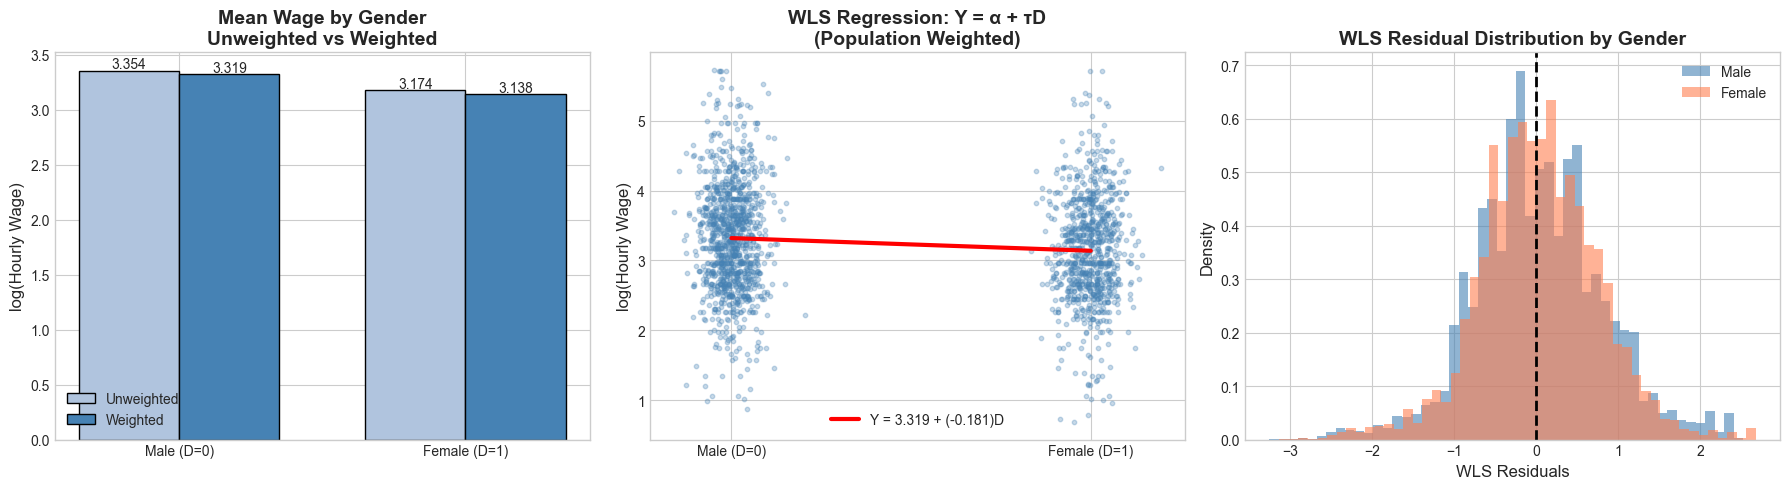

In [52]:
# =============================================================================
# STEP 2 VISUALIZATIONS (3 Charts)
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chart 1: Mean Wage by Gender (Weighted vs Unweighted)
ax1 = axes[0]
unweighted_means = [Y[D==0].mean(), Y[D==1].mean()]
weighted_means = [weighted_mean(Y[D==0], W[D==0]), weighted_mean(Y[D==1], W[D==1])]
x_pos = np.arange(2)
width = 0.35
bars1 = ax1.bar(x_pos - width/2, unweighted_means, width, label='Unweighted', color='lightsteelblue', edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, weighted_means, width, label='Weighted', color='steelblue', edgecolor='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Male (D=0)', 'Female (D=1)'])
y_label = 'log(Hourly Wage)' if USE_LOG else 'Hourly Wage ($)'
ax1.set_ylabel(y_label, fontsize=12)
ax1.set_title('Mean Wage by Gender\nUnweighted vs Weighted', fontsize=14, fontweight='bold')
ax1.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{bar.get_height():.3f}', ha='center', fontsize=10)

# Chart 2: Regression Line
ax2 = axes[1]
# Sample for visualization
sample_idx = np.random.choice(len(D), min(2000, len(D)), replace=False)
jitter = np.random.normal(0, 0.05, len(sample_idx))
ax2.scatter(D[sample_idx] + jitter, Y[sample_idx], alpha=0.3, s=10, c='steelblue')
# Regression line
x_line = np.array([0, 1])
y_line = model_bivariate.params[0] + model_bivariate.params[1] * x_line
ax2.plot(x_line, y_line, 'r-', linewidth=3, label=f'Y = {model_bivariate.params[0]:.3f} + ({tau_bivariate:.3f})D')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Male (D=0)', 'Female (D=1)'])
ax2.set_ylabel(y_label, fontsize=12)
ax2.set_title('WLS Regression: Y = α + τD\n(Population Weighted)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

# Chart 3: Residual Distribution
ax3 = axes[2]
residuals = model_bivariate.resid
ax3.hist(residuals[D==0], bins=50, alpha=0.6, label='Male', color='steelblue', density=True)
ax3.hist(residuals[D==1], bins=50, alpha=0.6, label='Female', color='coral', density=True)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax3.set_xlabel('WLS Residuals', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('WLS Residual Distribution by Gender', fontsize=14, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()



---

# ✅ STEP 3 — WEIGHTED OLS REGRESSION (Y ON D AND X)

## WLS with Controls: Estimating the Adjusted Gender Effect

**Model**: $Y_i = \alpha + \theta D_i + X_i'\beta + \varepsilon_i$

**Weighted Least Squares Objective**:
$$\min_{\alpha, \theta, \beta} \sum_{i=1}^{n} w_i (Y_i - \alpha - \theta D_i - X_i'\beta)^2$$

Now we control for observable characteristics $X$ to estimate the **population-weighted adjusted** gender wage gap.

---

In [53]:
# =============================================================================
# STEP 3: UNADJUSTED WLS (for comparison)
# =============================================================================

print("📊 UNADJUSTED WLS REGRESSION")
print(f"   Model: Y = α + θ*D + ε (weighted)")
print(f"   Where Y = {'log(Hourly Wage)' if USE_LOG else 'Hourly Wage ($)'}")
print("="*70)

X_unadj = sm.add_constant(D)
model_unadj = sm.WLS(Y, X_unadj, weights=W).fit(cov_type='HC3')
print(model_unadj.summary())



📊 UNADJUSTED WLS REGRESSION
   Model: Y = α + θ*D + ε (weighted)
   Where Y = log(Hourly Wage)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            WLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     542.0
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          2.44e-119
Time:                        00:57:29   Log-Likelihood:                -72196.
No. Observations:               57619   AIC:                         1.444e+05
Df Residuals:                   57617   BIC:                         1.444e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

In [54]:
tau_unadj = model_unadj.params[1]
se_unadj = model_unadj.bse[1]
all_results['Unadjusted WLS'] = print_results_box(tau_unadj, se_unadj, "UNADJUSTED WLS")




══════════════════════════════════════════════════════════════════════
📊 UNADJUSTED WLS RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1813 log($/hr) │
│ Standard Error                                              0.0078 │
│ t-statistic                                                 -23.28 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.1965, -0.1660] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8342 │
│ Gender Wage Gap (%)                                         16.58% │
│ 95% CI for Gap (%)                                [15.29%, 17.84%] │
═════════════════════════════════

In [55]:
# =============================================================================
# STEP 3: ADJUSTED WLS (with controls X)
# =============================================================================

print("\n📊 ADJUSTED WLS REGRESSION")
print(f"   Model: Y = α + θ*D + X'β + ε (weighted)")
print("="*70)

X_with_D = np.column_stack([D, X])
X_adj = sm.add_constant(X_with_D)
model_adj = sm.WLS(Y, X_adj, weights=W).fit(cov_type='HC3')

print(f"\n📋 Model Statistics:")
print(f"   R-squared: {model_adj.rsquared:.4f}")
print(f"   Adj. R-squared: {model_adj.rsquared_adj:.4f}")
print(f"   F-statistic: {model_adj.fvalue:.2f}")
print(f"   Observations: {int(model_adj.nobs):,}")
print(f"\n   ✅ This is the POPULATION-WEIGHTED adjusted gender wage gap")




📊 ADJUSTED WLS REGRESSION
   Model: Y = α + θ*D + X'β + ε (weighted)

📋 Model Statistics:
   R-squared: 0.4082
   Adj. R-squared: 0.4075
   F-statistic: 406.65
   Observations: 57,619

   ✅ This is the POPULATION-WEIGHTED adjusted gender wage gap


In [56]:
tau_adj = model_adj.params[1]
se_adj = model_adj.bse[1]
all_results['Adjusted WLS'] = print_results_box(tau_adj, se_adj, "ADJUSTED WLS")




══════════════════════════════════════════════════════════════════════
📊 ADJUSTED WLS RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1828 log($/hr) │
│ Standard Error                                              0.0071 │
│ t-statistic                                                 -25.91 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.1966, -0.1690] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8329 │
│ Gender Wage Gap (%)                                         16.71% │
│ 95% CI for Gap (%)                                [15.55%, 17.85%] │
═══════════════════════════════════

In [57]:
# =============================================================================
# DISPLAY TOP 30 COEFFICIENTS FROM ADJUSTED WLS
# =============================================================================

print("\n" + "="*90)
print("📊 TOP 30 COEFFICIENTS FROM ADJUSTED WLS REGRESSION (Y ~ D + X)")
print("="*90)

# Variable names: const, D (treatment), then all X variables
var_names = ['const', 'D (Female)'] + feature_cols

coef_df_adj = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': model_adj.params,
    'Std Error': model_adj.bse,
    't-statistic': model_adj.tvalues,
    'p-value': model_adj.pvalues
})

# Sort by absolute coefficient value (excluding constant)
coef_df_adj['Abs_Coef'] = coef_df_adj['Coefficient'].abs()
coef_df_adj_sorted = coef_df_adj[coef_df_adj['Variable'] != 'const'].sort_values('Abs_Coef', ascending=False)

# Display top 30
print(f"\n{'Rank':<6} {'Variable':<40} {'Coefficient':>12} {'Std Error':>12} {'t-stat':>10} {'p-value':>12}")
print("-"*94)

for rank, (idx, row) in enumerate(coef_df_adj_sorted.head(30).iterrows(), 1):
    var_name = row['Variable'][:38] if len(row['Variable']) > 38 else row['Variable']
    sig = '***' if row['p-value'] < 0.001 else '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else ''
    print(f"{rank:<6} {var_name:<40} {row['Coefficient']:>12.4f} {row['Std Error']:>12.4f} {row['t-statistic']:>10.2f} {row['p-value']:>10.2e} {sig}")

print("-"*94)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print(f"\n📝 Note: D (Female) coefficient = {tau_adj:.4f} (gender wage gap after controlling for X)")




📊 TOP 30 COEFFICIENTS FROM ADJUSTED WLS REGRESSION (Y ~ D + X)

Rank   Variable                                  Coefficient    Std Error     t-stat      p-value
----------------------------------------------------------------------------------------------
1      STATEFIP_freq                                  0.5384       0.0173      31.11  1.89e-212 ***
2      EDUC_5+ years of college                       0.4666       0.0130      35.91  1.84e-282 ***
3      IND_sector_Information                         0.3903       0.0336      11.62   3.24e-31 ***
4      OCC_category_Transportation                   -0.3857       0.0183     -21.13   4.12e-99 ***
5      OCC_category_Healthcare Support               -0.3604       0.0221     -16.29   1.13e-59 ***
6      OCC_category_Food Service                     -0.3467       0.0252     -13.76   4.68e-43 ***
7      OCC_category_Production                       -0.3110       0.0177     -17.57   4.52e-69 ***
8      EDUC_Nursery school to grade 4     

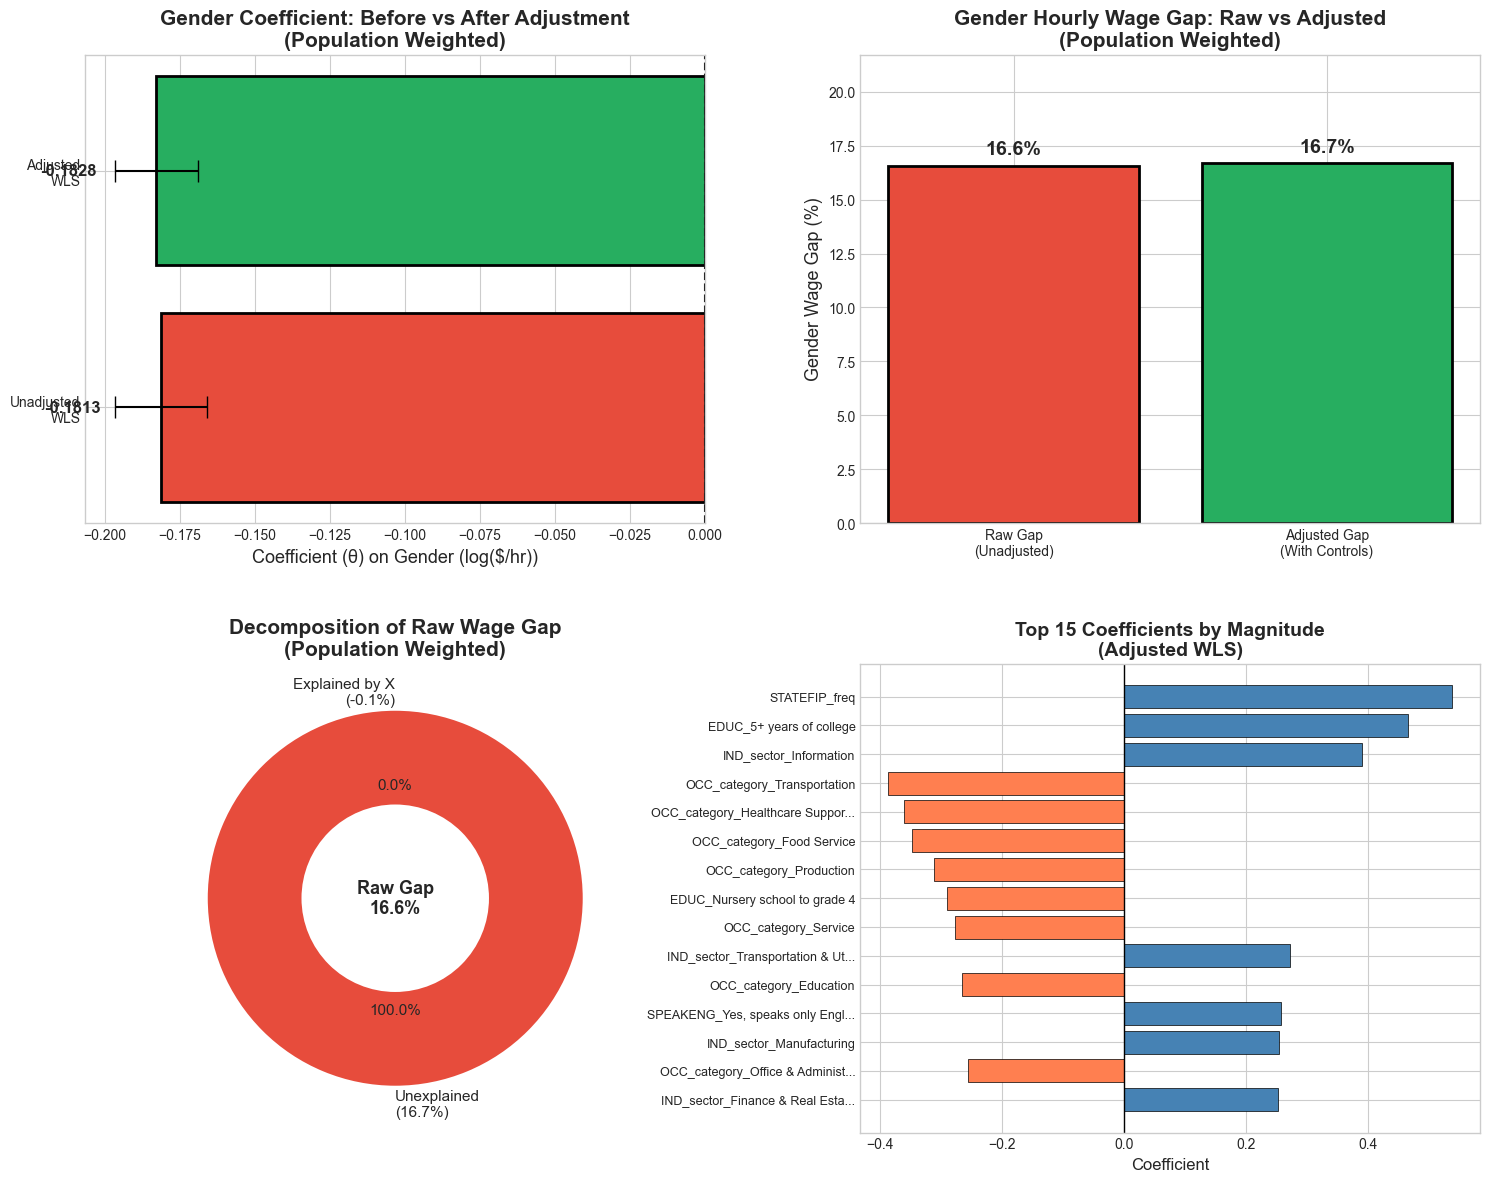

In [58]:
# =============================================================================
# STEP 3 VISUALIZATIONS (4 Charts)
# =============================================================================

fig = plt.figure(figsize=(18, 14))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Chart 1: Coefficient Comparison (Unadjusted vs Adjusted)
ax1 = fig.add_subplot(gs[0, 0])
methods = ['Unadjusted\nWLS', 'Adjusted\nWLS']
coefs = [tau_unadj, tau_adj]
errors = [1.96*se_unadj, 1.96*se_adj]
colors = ['#e74c3c', '#27ae60']
bars = ax1.barh(methods, coefs, xerr=errors, color=colors, capsize=8, edgecolor='black', linewidth=2)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
unit_label = 'log($/hr)' if USE_LOG else '$/hr'
ax1.set_xlabel(f'Coefficient (θ) on Gender ({unit_label})', fontsize=13)
ax1.set_title('Gender Coefficient: Before vs After Adjustment\n(Population Weighted)', fontsize=15, fontweight='bold')
for i, (c, e) in enumerate(zip(coefs, errors)):
    ax1.text(c - 0.02, i, f'{c:.4f}', va='center', ha='right', fontsize=12, fontweight='bold')

# Chart 2: Wage Gap Comparison
ax2 = fig.add_subplot(gs[0, 1])
gaps = [all_results['Unadjusted WLS']['gap_pct'], all_results['Adjusted WLS']['gap_pct']]
bars = ax2.bar(['Raw Gap\n(Unadjusted)', 'Adjusted Gap\n(With Controls)'], gaps, 
               color=colors, edgecolor='black', linewidth=2)
ax2.set_ylabel('Gender Wage Gap (%)', fontsize=13)
ax2.set_title('Gender Hourly Wage Gap: Raw vs Adjusted\n(Population Weighted)', fontsize=15, fontweight='bold')
for bar, gap in zip(bars, gaps):
    ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f'{gap:.1f}%', 
             ha='center', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(gaps)*1.3)

# Chart 3: Decomposition Pie Chart
ax3 = fig.add_subplot(gs[1, 0])
explained = gaps[0] - gaps[1]
unexplained = gaps[1]
sizes = [max(0, explained), max(0, unexplained)]
labels = [f'Explained by X\n({explained:.1f}%)', f'Unexplained\n({unexplained:.1f}%)']
colors_pie = ['#95a5a6', '#e74c3c']
if sum(sizes) > 0:
    wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors_pie,
                                        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
    centre_circle = plt.Circle((0,0), 0.50, fc='white')
    ax3.add_patch(centre_circle)
    ax3.text(0, 0, f'Raw Gap\n{gaps[0]:.1f}%', ha='center', va='center', fontsize=13, fontweight='bold')
ax3.set_title('Decomposition of Raw Wage Gap\n(Population Weighted)', fontsize=15, fontweight='bold')

# Chart 4: Top 15 Coefficients
ax4 = fig.add_subplot(gs[1, 1])
top15 = coef_df_adj_sorted.head(15).copy()
top15 = top15.iloc[::-1]  # Reverse for plotting
colors_coef = ['coral' if c < 0 else 'steelblue' for c in top15['Coefficient']]
y_pos = range(len(top15))
ax4.barh(y_pos, top15['Coefficient'], color=colors_coef, edgecolor='black', linewidth=0.5)
ax4.set_yticks(y_pos)
ax4.set_yticklabels([v[:30] + '...' if len(v) > 30 else v for v in top15['Variable']], fontsize=9)
ax4.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Coefficient', fontsize=12)
ax4.set_title('Top 15 Coefficients by Magnitude\n(Adjusted WLS)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



---

# ✅ STEP 4 — WEIGHTED LINEAR PROBABILITY MODEL (D ON X)

## Understanding Selection: Who is Female in the Population?

**Model**: $D_i = X_i'\gamma + \nu_i$ (weighted by $w_i$)

**Weighted Objective**:
$$\min_{\gamma} \sum_{i=1}^{n} w_i (D_i - X_i'\gamma)^2$$

This weighted linear probability model shows how covariates X predict being female in the **population**.

---

In [59]:
# =============================================================================
# STEP 4: WEIGHTED LINEAR PROBABILITY MODEL (D ~ X)
# =============================================================================

print("📊 WEIGHTED LINEAR PROBABILITY MODEL: D on X")
print("   Model: D = X'γ + ν (weighted by W)")
print("="*70)

X_const = sm.add_constant(X_scaled)
model_treat_linear = sm.WLS(D, X_const, weights=W).fit(cov_type='HC3')

D_pred_linear = model_treat_linear.predict(X_const)

print(f"\n📋 Model Summary:")
print(f"   R-squared: {model_treat_linear.rsquared:.4f}")
print(f"   This shows how much X predicts gender in the POPULATION")
print(f"   (Weighted by survey weights)")
print(f"\n   Interpretation: {model_treat_linear.rsquared*100:.1f}% of gender variation is explained by X")



📊 WEIGHTED LINEAR PROBABILITY MODEL: D on X
   Model: D = X'γ + ν (weighted by W)

📋 Model Summary:
   R-squared: 0.2204
   This shows how much X predicts gender in the POPULATION
   (Weighted by survey weights)

   Interpretation: 22.0% of gender variation is explained by X


In [60]:
print(model_treat_linear.summary())



                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.220
Model:                            WLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     284.2
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        00:57:31   Log-Likelihood:                -41088.
No. Observations:               57619   AIC:                         8.230e+04
Df Residuals:                   57555   BIC:                         8.288e+04
Df Model:                          63                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4319      0.002    188.451      0.0

---

# ✅ STEP 5 — WEIGHTED PROPENSITY SCORE + SUBCLASSIFICATION

## Weighted Propensity Score Estimation

The propensity score is estimated using **weighted logistic regression**:

$$\hat{e}(X_i) = P(D_i = 1 | X_i)$$

**Weighted Log-Likelihood**:
$$\max_{\gamma} \sum_{i=1}^{n} w_i \left[ D_i \log(e(X_i; \gamma)) + (1-D_i) \log(1-e(X_i; \gamma)) \right]$$

## Weighted Subclassification ATE

$$\hat{\tau}_{sub,w} = \sum_{k=1}^{K} \frac{W_k}{W_{total}} \hat{\tau}_k$$

Where within each stratum:
$$\hat{\tau}_k = \bar{Y}_{w,1,k} - \bar{Y}_{w,0,k} = \frac{\sum_{i \in k: D_i=1} w_i Y_i}{\sum_{i \in k: D_i=1} w_i} - \frac{\sum_{i \in k: D_i=0} w_i Y_i}{\sum_{i \in k: D_i=0} w_i}$$

---

In [61]:
# =============================================================================
# PROPENSITY SCORE ESTIMATION (WEIGHTED)
# =============================================================================

print("📊 PROPENSITY SCORE ESTIMATION (WEIGHTED)")
print("="*70)

# Use sample_weight for weighted logistic regression
ps_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, C=1.0)
ps_model.fit(X_scaled, D, sample_weight=W)
e_hat = ps_model.predict_proba(X_scaled)[:, 1]

print(f"\n📋 WEIGHTED Propensity Score Formula:")
print(f"   e(X) = P(D=1|X) estimated with survey weights")
print(f"   Maximize: Σᵢ wᵢ [Dᵢ log(e(Xᵢ)) + (1-Dᵢ) log(1-e(Xᵢ))]")

print(f"\n   PS Statistics:")
print(f"   Unweighted mean: {e_hat.mean():.4f}")
print(f"   Weighted mean: {weighted_mean(e_hat, W):.4f}")
print(f"   Min: {e_hat.min():.4f}, Max: {e_hat.max():.4f}")
print(f"   Male weighted mean: {weighted_mean(e_hat[D==0], W[D==0]):.4f}")
print(f"   Female weighted mean: {weighted_mean(e_hat[D==1], W[D==1]):.4f}")



📊 PROPENSITY SCORE ESTIMATION (WEIGHTED)

📋 WEIGHTED Propensity Score Formula:
   e(X) = P(D=1|X) estimated with survey weights
   Maximize: Σᵢ wᵢ [Dᵢ log(e(Xᵢ)) + (1-Dᵢ) log(1-e(Xᵢ))]

   PS Statistics:
   Unweighted mean: 0.4317
   Weighted mean: 0.4301
   Min: 0.0026, Max: 0.9640
   Male weighted mean: 0.3337
   Female weighted mean: 0.5577


In [62]:
# =============================================================================
# WEIGHTED SUBCLASSIFICATION
# =============================================================================

K = 10
ps_strata = pd.qcut(e_hat, q=K, labels=range(K), duplicates='drop')

print(f"\n📊 WEIGHTED SUBCLASSIFICATION (K={K} Strata)")
print("="*70)

print(f"\n📋 Weighted Subclassification Formula:")
print(f"   τ_sub,w = Σₖ (Wₖ/W_total) × τₖ")
print(f"   Where τₖ = weighted_mean(Y|D=1,k) - weighted_mean(Y|D=0,k)")

stratum_results = []
for k in range(K):
    mask = ps_strata == k
    if mask.sum() > 0:
        y_k = Y[mask]
        d_k = D[mask]
        w_k = W[mask]
        e_k = e_hat[mask]
        
        treated = d_k == 1
        control = d_k == 0
        
        if treated.sum() > 0 and control.sum() > 0:
            # Weighted means within stratum
            y1_w = weighted_mean(y_k[treated], w_k[treated])
            y0_w = weighted_mean(y_k[control], w_k[control])
            
            stratum_results.append({
                'stratum': k,
                'n': mask.sum(),
                'n_treated': treated.sum(),
                'n_control': control.sum(),
                'W_total': w_k.sum(),
                'W_treated': w_k[treated].sum(),
                'W_control': w_k[control].sum(),
                'ps_mean': weighted_mean(e_k, w_k),
                'y1_mean': y1_w,
                'y0_mean': y0_w,
                'tau_k': y1_w - y0_w
            })

stratum_df = pd.DataFrame(stratum_results)

print(f"\n{'Stratum':<8} {'W_total':>10} {'W_treat':>10} {'W_ctrl':>10} {'PS_mean':>8} {'Y1_w':>10} {'Y0_w':>10} {'τ_k':>10}")
print("-"*85)
for _, row in stratum_df.iterrows():
    print(f"{row['stratum']:<8} {row['W_total']:>10.0f} {row['W_treated']:>10.0f} {row['W_control']:>10.0f} {row['ps_mean']:>8.3f} {row['y1_mean']:>10.4f} {row['y0_mean']:>10.4f} {row['tau_k']:>10.4f}")

# Weighted ATE across strata
W_total_all = stratum_df['W_total'].sum()
tau_sub = (stratum_df['tau_k'] * stratum_df['W_total']).sum() / W_total_all

print("-"*85)
print(f"{'WEIGHTED ATE':<8} {W_total_all:>10.0f} {'':<10} {'':<10} {'':<8} {'':<10} {'':<10} {tau_sub:>10.4f}")




📊 WEIGHTED SUBCLASSIFICATION (K=10 Strata)

📋 Weighted Subclassification Formula:
   τ_sub,w = Σₖ (Wₖ/W_total) × τₖ
   Where τₖ = weighted_mean(Y|D=1,k) - weighted_mean(Y|D=0,k)

Stratum     W_total    W_treat     W_ctrl  PS_mean       Y1_w       Y0_w        τ_k
-------------------------------------------------------------------------------------
0.0            6168        383       5785    0.059     2.8708     3.1180    -0.2471
1.0            5620        994       4626    0.177     3.0928     3.3497    -0.2569
2.0            5790       1339       4452    0.249     3.1739     3.3705    -0.1966
3.0            5700       1756       3944    0.312     3.1996     3.4060    -0.2064
4.0            5599       2195       3404    0.380     3.2483     3.4273    -0.1790
5.0            5803       2623       3180    0.450     3.1133     3.2964    -0.1831
6.0            5729       3134       2595    0.534     3.2225     3.3962    -0.1737
7.0            5559       3484       2075    0.626     3.2542 

In [63]:
# =============================================================================
# WEIGHTED BOOTSTRAP SE FOR SUBCLASSIFICATION
# =============================================================================

def compute_weighted_subclass_ate(y, d, strata, w):
    """Compute weighted subclassification ATE."""
    effects, weights = [], []
    for k in np.unique(strata):
        mask = strata == k
        y_k, d_k, w_k = y[mask], d[mask], w[mask]
        
        if (d_k == 1).sum() > 0 and (d_k == 0).sum() > 0:
            y_1, w_1 = y_k[d_k == 1], w_k[d_k == 1]
            y_0, w_0 = y_k[d_k == 0], w_k[d_k == 0]
            
            tau_k = weighted_mean(y_1, w_1) - weighted_mean(y_0, w_0)
            W_k = w_k.sum()
            
            effects.append(tau_k)
            weights.append(W_k)
    
    total_W = sum(weights)
    return sum(wt * t for wt, t in zip(weights, effects)) / total_W if total_W > 0 else 0

print("\n📊 WEIGHTED BOOTSTRAP SE")
print("   Method: Resample with replacement, probabilities ∝ survey weights")
print("="*70)

# Weighted bootstrap: sample with probabilities proportional to W
W_probs = W / W.sum()

boot_tau_sub = []
np.random.seed(RANDOM_STATE)
for b in range(500):
    idx = np.random.choice(len(Y), len(Y), replace=True, p=W_probs)
    ate_boot = compute_weighted_subclass_ate(Y[idx], D[idx], ps_strata[idx], W[idx])
    boot_tau_sub.append(ate_boot)

se_sub = np.std(boot_tau_sub)
print(f"   Bootstrap iterations: 500")
print(f"   Bootstrap SE: {se_sub:.4f}")

all_results['Subclassification'] = print_results_box(tau_sub, se_sub, "SUBCLASSIFICATION (WEIGHTED)")




📊 WEIGHTED BOOTSTRAP SE
   Method: Resample with replacement, probabilities ∝ survey weights
   Bootstrap iterations: 500
   Bootstrap SE: 0.0096

══════════════════════════════════════════════════════════════════════
📊 SUBCLASSIFICATION (WEIGHTED) RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1920 log($/hr) │
│ Standard Error                                              0.0096 │
│ t-statistic                                                 -20.01 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.2108, -0.1732] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8253 │
│ Gender Wage 

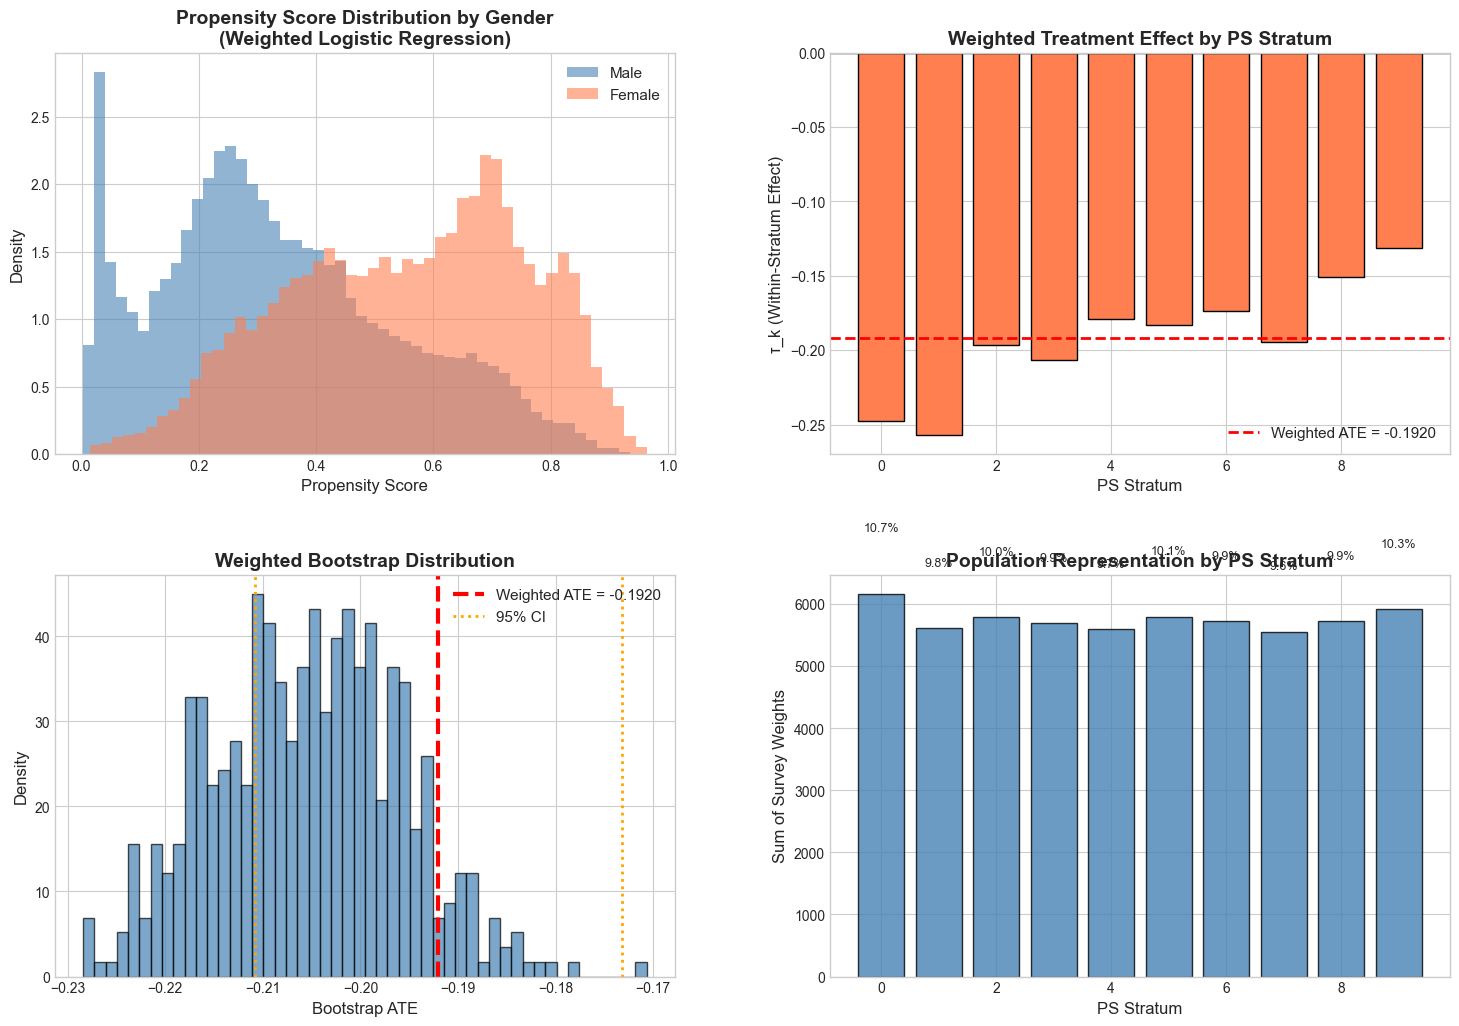

In [64]:
# =============================================================================
# STEP 5 VISUALIZATIONS (4 Charts)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Chart 1: PS Distribution by Gender
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(e_hat[D==0], bins=50, alpha=0.6, label='Male', color='steelblue', density=True)
ax1.hist(e_hat[D==1], bins=50, alpha=0.6, label='Female', color='coral', density=True)
ax1.set_xlabel('Propensity Score', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Propensity Score Distribution by Gender\n(Weighted Logistic Regression)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)

# Chart 2: Stratum Effects
ax2 = fig.add_subplot(gs[0, 1])
colors_stratum = ['coral' if t < 0 else 'steelblue' for t in stratum_df['tau_k']]
bars = ax2.bar(stratum_df['stratum'], stratum_df['tau_k'], color=colors_stratum, edgecolor='black')
ax2.axhline(y=tau_sub, color='red', linestyle='--', linewidth=2, label=f'Weighted ATE = {tau_sub:.4f}')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('PS Stratum', fontsize=12)
ax2.set_ylabel('τ_k (Within-Stratum Effect)', fontsize=12)
ax2.set_title('Weighted Treatment Effect by PS Stratum', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

# Chart 3: Bootstrap Distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(boot_tau_sub, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(x=tau_sub, color='red', linestyle='--', linewidth=3, label=f'Weighted ATE = {tau_sub:.4f}')
ax3.axvline(x=tau_sub - 1.96*se_sub, color='orange', linestyle=':', linewidth=2)
ax3.axvline(x=tau_sub + 1.96*se_sub, color='orange', linestyle=':', linewidth=2, label='95% CI')
ax3.set_xlabel('Bootstrap ATE', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Weighted Bootstrap Distribution', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)

# Chart 4: Weight Distribution by Stratum
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(stratum_df['stratum'], stratum_df['W_total'], color='steelblue', edgecolor='black', alpha=0.8)
ax4.set_xlabel('PS Stratum', fontsize=12)
ax4.set_ylabel('Sum of Survey Weights', fontsize=12)
ax4.set_title('Population Representation by PS Stratum', fontsize=14, fontweight='bold')
for i, row in stratum_df.iterrows():
    ax4.text(row['stratum'], row['W_total'] + 1000, f"{row['W_total']/W_total_all*100:.1f}%", 
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()



---

## ⚠️ LIMITATIONS OF PROPENSITY SCORE SUBCLASSIFICATION

| Limitation | Description |
|------------|-------------|
| **Residual Confounding** | Even within strata, covariates may not be perfectly balanced |
| **Choice of K** | Results can be sensitive to number of strata |
| **Sparse Strata** | Some strata may have few treated/control units |
| **Discrete Adjustment** | Only adjusts at stratum level, not continuously |
| **No Closed-Form SE** | Standard errors require bootstrap |
| **No Outcome Modeling** | Ignores outcome variable structure |

**→ IPW uses propensity scores as continuous weights.**

---

---

# ✅ STEP 6 — WEIGHTED INVERSE PROBABILITY WEIGHTING (IPW)

## Combining Survey Weights with IPW Weights

IPW creates a pseudo-population where treatment is independent of X. With survey weights, we combine both:

**Weighted IPW Estimator**:

$$\hat{\tau}_{IPW,w} = \frac{\sum_{i=1}^{n} w_i \frac{D_i Y_i}{\hat{e}(X_i)}}{\sum_{i=1}^{n} w_i \frac{D_i}{\hat{e}(X_i)}} - \frac{\sum_{i=1}^{n} w_i \frac{(1-D_i) Y_i}{1-\hat{e}(X_i)}}{\sum_{i=1}^{n} w_i \frac{(1-D_i)}{1-\hat{e}(X_i)}}$$

Where:
- $w_i$ = Survey weight (PERWT, normalized)
- $\hat{e}(X_i)$ = Estimated propensity score

This produces **doubly-weighted** estimates: population-representative AND causal.

---

In [65]:
# =============================================================================
# WEIGHTED IPW ESTIMATION
# =============================================================================

print("📊 WEIGHTED INVERSE PROBABILITY WEIGHTING (IPW)")
print("="*70)

# Trimming propensity scores to avoid extreme weights
trim_lower, trim_upper = 0.1, 0.9
trim_mask = (e_hat >= trim_lower) & (e_hat <= trim_upper)

Y_trim = Y[trim_mask]
D_trim = D[trim_mask]
e_trim = e_hat[trim_mask]
W_trim = W[trim_mask]  # Survey weights after trimming

print(f"\n   Trimming bounds: [{trim_lower}, {trim_upper}]")
print(f"   Observations trimmed: {(~trim_mask).sum():,} ({(~trim_mask).mean()*100:.1f}%)")
print(f"   Remaining observations: {trim_mask.sum():,}")
print(f"   Sum of remaining survey weights: {W_trim.sum():,.0f}")

# =============================================================================
# WEIGHTED IPW FORMULA:
# τ_IPW,w = [Σ w_i * D_i * Y_i / e_i] / [Σ w_i * D_i / e_i]
#         - [Σ w_i * (1-D_i) * Y_i / (1-e_i)] / [Σ w_i * (1-D_i) / (1-e_i)]
# =============================================================================

print(f"\n📋 WEIGHTED IPW Formula:")
print(f"   τ_IPW,w = [Σ wᵢ Dᵢ Yᵢ / eᵢ] / [Σ wᵢ Dᵢ / eᵢ]")
print(f"           - [Σ wᵢ (1-Dᵢ) Yᵢ / (1-eᵢ)] / [Σ wᵢ (1-Dᵢ) / (1-eᵢ)]")

# Compute weighted IPW estimator
num_treated = np.sum(W_trim * D_trim * Y_trim / e_trim)
denom_treated = np.sum(W_trim * D_trim / e_trim)
E_Y1_w = num_treated / denom_treated

num_control = np.sum(W_trim * (1-D_trim) * Y_trim / (1-e_trim))
denom_control = np.sum(W_trim * (1-D_trim) / (1-e_trim))
E_Y0_w = num_control / denom_control

tau_ipw = E_Y1_w - E_Y0_w

print(f"\n📋 WEIGHTED IPW Results:")
print(f"   E[Y(1)]_w (weighted): {E_Y1_w:.4f}")
print(f"   E[Y(0)]_w (weighted): {E_Y0_w:.4f}")
print(f"   τ_IPW,w: {tau_ipw:.4f}")



📊 WEIGHTED INVERSE PROBABILITY WEIGHTING (IPW)

   Trimming bounds: [0.1, 0.9]
   Observations trimmed: 5,146 (8.9%)
   Remaining observations: 52,473
   Sum of remaining survey weights: 52,089

📋 WEIGHTED IPW Formula:
   τ_IPW,w = [Σ wᵢ Dᵢ Yᵢ / eᵢ] / [Σ wᵢ Dᵢ / eᵢ]
           - [Σ wᵢ (1-Dᵢ) Yᵢ / (1-eᵢ)] / [Σ wᵢ (1-Dᵢ) / (1-eᵢ)]

📋 WEIGHTED IPW Results:
   E[Y(1)]_w (weighted): 3.1537
   E[Y(0)]_w (weighted): 3.3356
   τ_IPW,w: -0.1819


In [66]:
# =============================================================================
# WEIGHTED BOOTSTRAP SE FOR IPW
# =============================================================================

def compute_weighted_ipw_ate(Y, D, e, W):
    """Compute weighted IPW ATE."""
    num_treated = np.sum(W * D * Y / e)
    denom_treated = np.sum(W * D / e)
    E_Y1 = num_treated / denom_treated if denom_treated > 0 else 0
    
    num_control = np.sum(W * (1-D) * Y / (1-e))
    denom_control = np.sum(W * (1-D) / (1-e))
    E_Y0 = num_control / denom_control if denom_control > 0 else 0
    
    return E_Y1 - E_Y0

print("\n📊 WEIGHTED BOOTSTRAP SE FOR IPW")
print("="*70)

# Weighted bootstrap: resample with probabilities proportional to survey weights
W_trim_probs = W_trim / W_trim.sum()

boot_ipw = []
np.random.seed(RANDOM_STATE)
for _ in range(500):
    idx = np.random.choice(len(Y_trim), len(Y_trim), replace=True, p=W_trim_probs)
    boot_ipw.append(compute_weighted_ipw_ate(Y_trim[idx], D_trim[idx], e_trim[idx], W_trim[idx]))

boot_ipw = np.array(boot_ipw)
se_ipw = np.std(boot_ipw)

print(f"   Bootstrap iterations: 500")
print(f"   Bootstrap SE: {se_ipw:.4f}")
print(f"   95% CI: [{tau_ipw - 1.96*se_ipw:.4f}, {tau_ipw + 1.96*se_ipw:.4f}]")

all_results['IPW'] = print_results_box(tau_ipw, se_ipw, "IPW (WEIGHTED)")




📊 WEIGHTED BOOTSTRAP SE FOR IPW
   Bootstrap iterations: 500
   Bootstrap SE: 0.0089
   95% CI: [-0.1994, -0.1645]

══════════════════════════════════════════════════════════════════════
📊 IPW (WEIGHTED) RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1819 log($/hr) │
│ Standard Error                                              0.0089 │
│ t-statistic                                                 -20.49 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.1994, -0.1645] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8336 │
│ Gender Wage Gap (%)                                      

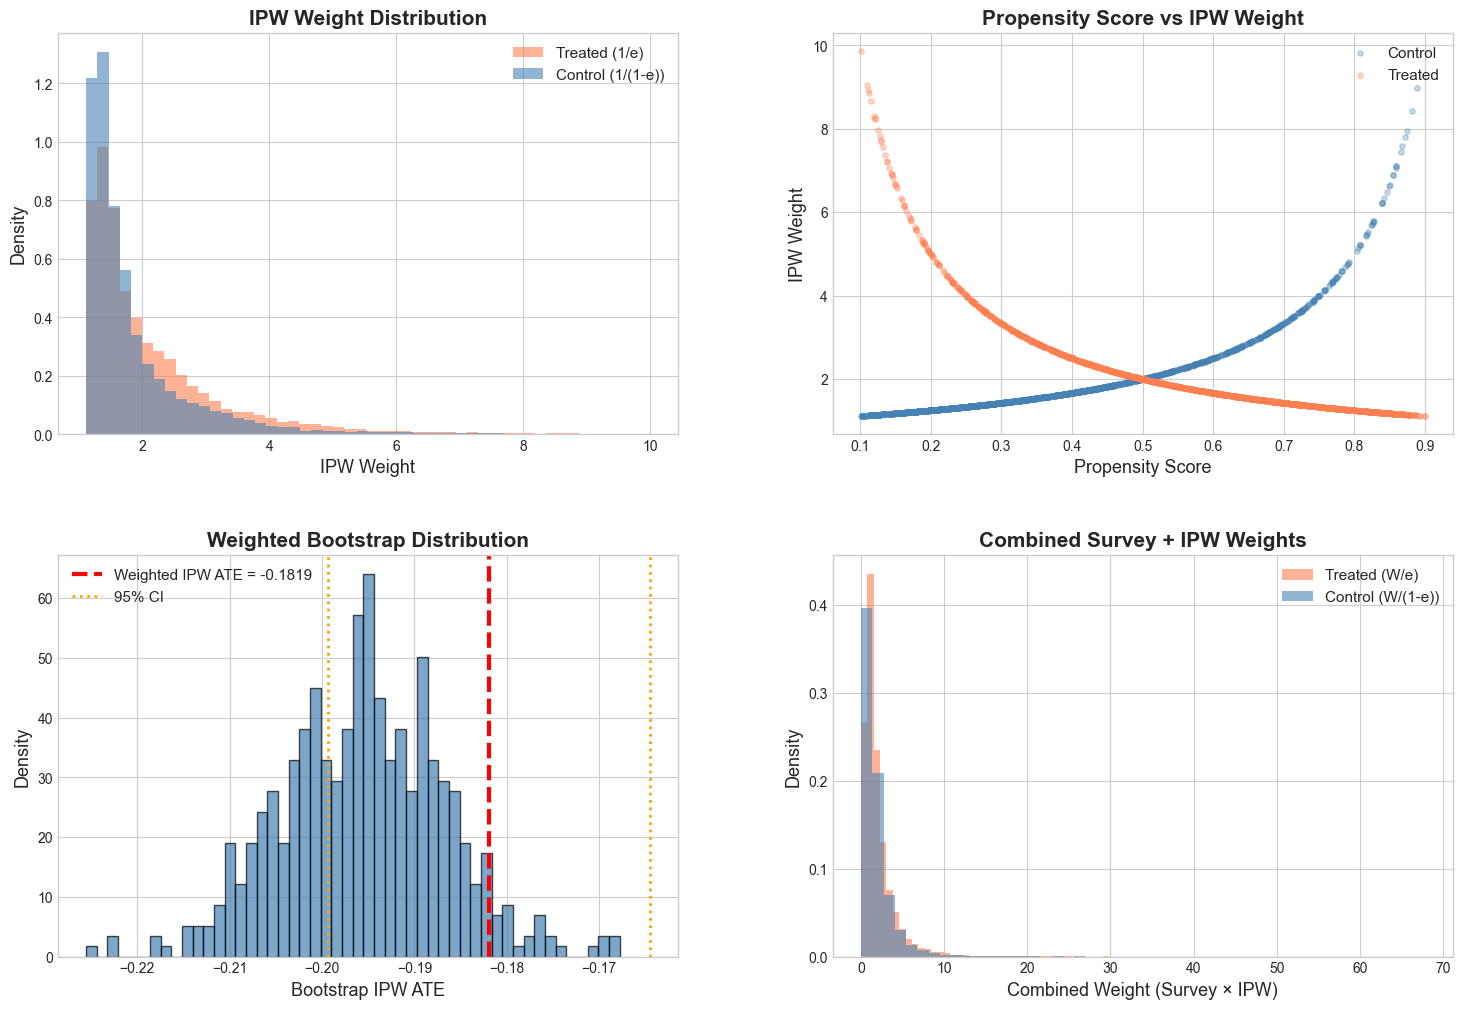

In [67]:
# =============================================================================
# STEP 6: IPW VISUALIZATIONS (4 Charts)
# =============================================================================

weights_treated = 1 / e_trim
weights_control = 1 / (1 - e_trim)

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Chart 1: IPW Weight Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(weights_treated[D_trim==1], bins=50, alpha=0.6, label='Treated (1/e)', color='coral', density=True)
ax1.hist(weights_control[D_trim==0], bins=50, alpha=0.6, label='Control (1/(1-e))', color='steelblue', density=True)
ax1.set_xlabel('IPW Weight', fontsize=13)
ax1.set_ylabel('Density', fontsize=13)
ax1.set_title('IPW Weight Distribution', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)

# Chart 2: PS vs IPW Weight
ax2 = fig.add_subplot(gs[0, 1])
sample_idx = np.random.choice(len(e_trim), min(3000, len(e_trim)), replace=False)
ax2.scatter(e_trim[sample_idx][D_trim[sample_idx]==0], weights_control[sample_idx][D_trim[sample_idx]==0], 
            alpha=0.3, s=15, c='steelblue', label='Control')
ax2.scatter(e_trim[sample_idx][D_trim[sample_idx]==1], weights_treated[sample_idx][D_trim[sample_idx]==1], 
            alpha=0.3, s=15, c='coral', label='Treated')
ax2.set_xlabel('Propensity Score', fontsize=13)
ax2.set_ylabel('IPW Weight', fontsize=13)
ax2.set_title('Propensity Score vs IPW Weight', fontsize=15, fontweight='bold')
ax2.legend(fontsize=11)

# Chart 3: Bootstrap Distribution
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(boot_ipw, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(x=tau_ipw, color='red', linestyle='--', linewidth=3, label=f'Weighted IPW ATE = {tau_ipw:.4f}')
ax3.axvline(x=tau_ipw - 1.96*se_ipw, color='orange', linestyle=':', linewidth=2)
ax3.axvline(x=tau_ipw + 1.96*se_ipw, color='orange', linestyle=':', linewidth=2, label='95% CI')
ax3.set_xlabel('Bootstrap IPW ATE', fontsize=13)
ax3.set_ylabel('Density', fontsize=13)
ax3.set_title('Weighted Bootstrap Distribution', fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)

# Chart 4: Combined Weights (Survey × IPW)
ax4 = fig.add_subplot(gs[1, 1])
combined_weights_t = W_trim[D_trim==1] / e_trim[D_trim==1]
combined_weights_c = W_trim[D_trim==0] / (1 - e_trim[D_trim==0])
ax4.hist(combined_weights_t, bins=50, alpha=0.6, label='Treated (W/e)', color='coral', density=True)
ax4.hist(combined_weights_c, bins=50, alpha=0.6, label='Control (W/(1-e))', color='steelblue', density=True)
ax4.set_xlabel('Combined Weight (Survey × IPW)', fontsize=13)
ax4.set_ylabel('Density', fontsize=13)
ax4.set_title('Combined Survey + IPW Weights', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11)

plt.tight_layout()
plt.show()



---

## ⚠️ LIMITATIONS OF IPW

| Limitation | Description |
|------------|-------------|
| **Extreme Weights** | PS near 0 or 1 creates large, unstable weights |
| **Requires Trimming** | Extreme observations often trimmed (loses data) |
| **PS Model Dependence** | Results sensitive to propensity score specification |
| **No Outcome Modeling** | Ignores outcome variable structure |
| **High Variance** | Can have higher variance than outcome regression |

**→ Doubly Robust (AIPW) combines outcome modeling with IPW for robustness.**

---

---

# ✅ STEP 7 — WEIGHTED DOUBLY ROBUST (AIPW)

## Combining Outcome Modeling with IPW (Survey Weighted)

The Augmented IPW (AIPW) estimator is **doubly robust**: consistent if EITHER the outcome model OR the propensity score model is correct.

**Weighted AIPW Estimator**:

$$\hat{\tau}_{AIPW,w} = \frac{1}{\sum w_i} \sum_{i=1}^{n} w_i \left[ \hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{D_i(Y_i - \hat{\mu}_1(X_i))}{\hat{e}(X_i)} - \frac{(1-D_i)(Y_i - \hat{\mu}_0(X_i))}{1-\hat{e}(X_i)} \right]$$

Where:
- $w_i$ = Survey weight
- $\hat{\mu}_1(X_i) = E[Y|X_i, D=1]$ (outcome model for treated, weighted)
- $\hat{\mu}_0(X_i) = E[Y|X_i, D=0]$ (outcome model for control, weighted)
- $\hat{e}(X_i) = P(D=1|X_i)$ (propensity score, weighted)

All models are estimated with survey weights for population-representative inference.

---

In [68]:
# =============================================================================
# WEIGHTED DOUBLY ROBUST (AIPW) ESTIMATION
# =============================================================================

print("📊 WEIGHTED DOUBLY ROBUST (AIPW) ESTIMATION")
print("="*70)

# Fit WEIGHTED outcome models using Ridge regression with sample weights
from sklearn.linear_model import Ridge

# Outcome model for treated: E[Y|X, D=1]
X_treated = X_scaled[D==1]
Y_treated = Y[D==1]
W_treated = W[D==1]

outcome_model_1 = Ridge(alpha=1.0, random_state=RANDOM_STATE)
outcome_model_1.fit(X_treated, Y_treated, sample_weight=W_treated)
mu_1_hat = outcome_model_1.predict(X_scaled)  # Predict for all X

# Outcome model for control: E[Y|X, D=0]
X_control = X_scaled[D==0]
Y_control = Y[D==0]
W_control = W[D==0]

outcome_model_0 = Ridge(alpha=1.0, random_state=RANDOM_STATE)
outcome_model_0.fit(X_control, Y_control, sample_weight=W_control)
mu_0_hat = outcome_model_0.predict(X_scaled)  # Predict for all X

print(f"   ✅ Weighted outcome models fitted")
print(f"   Outcome model (treated) R²: {outcome_model_1.score(X_treated, Y_treated, sample_weight=W_treated):.4f}")
print(f"   Outcome model (control) R²: {outcome_model_0.score(X_control, Y_control, sample_weight=W_control):.4f}")

# =============================================================================
# WEIGHTED AIPW FORMULA:
# τ_AIPW,w = (1/Σwᵢ) × Σᵢ wᵢ × [μ₁(Xᵢ) - μ₀(Xᵢ) + D(Y-μ₁(X))/e - (1-D)(Y-μ₀(X))/(1-e)]
# =============================================================================

print(f"\n📋 WEIGHTED AIPW Formula:")
print(f"   τ_AIPW,w = (1/ΣWᵢ) × Σᵢ Wᵢ × [μ̂₁(Xᵢ) - μ̂₀(Xᵢ) + Dᵢ(Yᵢ-μ̂₁)/eᵢ - (1-Dᵢ)(Yᵢ-μ̂₀)/(1-eᵢ)]")

# Use trimmed propensity scores for stability
e_use = np.clip(e_hat, 0.1, 0.9)

# Augmentation terms
aug_treated = D * (Y - mu_1_hat) / e_use
aug_control = (1 - D) * (Y - mu_0_hat) / (1 - e_use)

# Individual-level AIPW scores
aipw_scores = (mu_1_hat - mu_0_hat) + aug_treated - aug_control

# Weighted average
W_total = W.sum()
tau_dr = np.sum(W * aipw_scores) / W_total

print(f"\n📋 WEIGHTED AIPW Components:")
print(f"   Outcome model contribution: {weighted_mean(mu_1_hat - mu_0_hat, W):.4f}")
print(f"   IPW augmentation contribution: {weighted_mean(aug_treated - aug_control, W):.4f}")
print(f"   Combined AIPW estimate: {tau_dr:.4f}")



📊 WEIGHTED DOUBLY ROBUST (AIPW) ESTIMATION
   ✅ Weighted outcome models fitted
   Outcome model (treated) R²: 0.3961
   Outcome model (control) R²: 0.4090

📋 WEIGHTED AIPW Formula:
   τ_AIPW,w = (1/ΣWᵢ) × Σᵢ Wᵢ × [μ̂₁(Xᵢ) - μ̂₀(Xᵢ) + Dᵢ(Yᵢ-μ̂₁)/eᵢ - (1-Dᵢ)(Yᵢ-μ̂₀)/(1-eᵢ)]

📋 WEIGHTED AIPW Components:
   Outcome model contribution: -0.1920
   IPW augmentation contribution: -0.0018
   Combined AIPW estimate: -0.1938


In [69]:
# =============================================================================
# WEIGHTED INFLUENCE FUNCTION SE
# =============================================================================

print("\n📊 WEIGHTED INFLUENCE FUNCTION SE")
print("="*70)

# Influence function for AIPW
psi = aipw_scores - tau_dr

# Weighted variance of influence function
var_psi = np.sum(W * psi**2) / W_total
n_eff = W_total**2 / np.sum(W**2)  # Effective sample size
se_dr = np.sqrt(var_psi / n_eff)

print(f"   Effective sample size: {n_eff:,.0f}")
print(f"   Weighted variance of influence function: {var_psi:.6f}")
print(f"   Influence function SE: {se_dr:.4f}")

all_results['Doubly Robust'] = print_results_box(tau_dr, se_dr, "DOUBLY ROBUST (AIPW, WEIGHTED)")




📊 WEIGHTED INFLUENCE FUNCTION SE
   Effective sample size: 35,578
   Weighted variance of influence function: 1.813603
   Influence function SE: 0.0071

══════════════════════════════════════════════════════════════════════
📊 DOUBLY ROBUST (AIPW, WEIGHTED) RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1938 log($/hr) │
│ Standard Error                                              0.0071 │
│ t-statistic                                                 -27.15 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.2078, -0.1798] │
│--------------------------------------------------------------------│
│ Wage Ratio (Female/Male)                                    0.8238 │
│ Gend

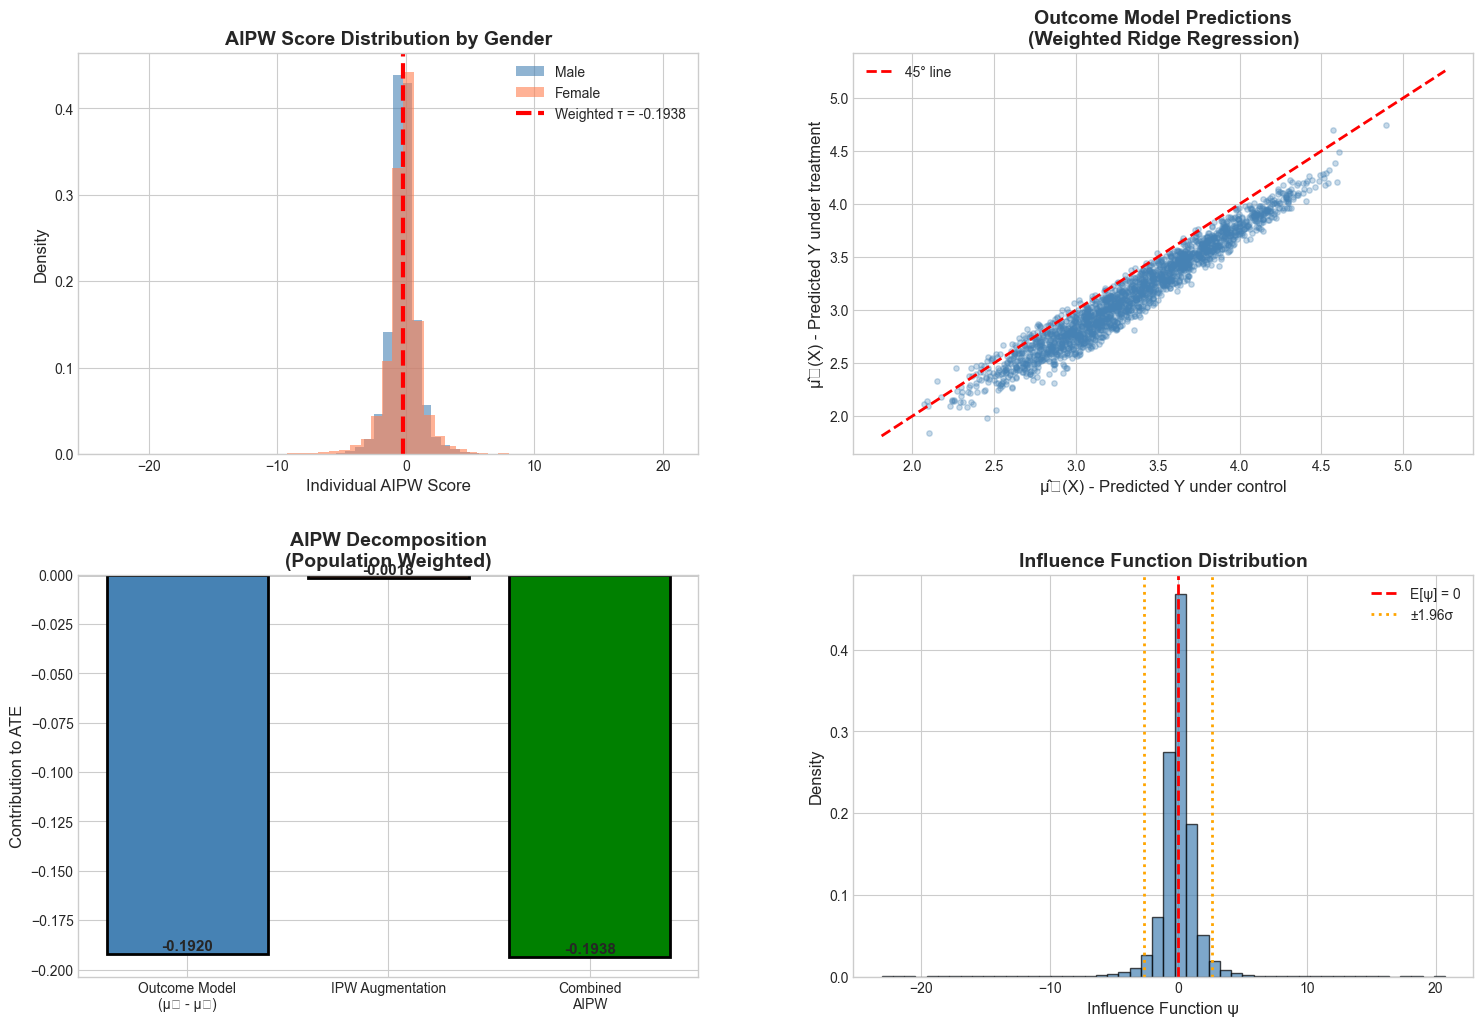

In [70]:
# =============================================================================
# STEP 7: DOUBLY ROBUST VISUALIZATIONS (4 Charts)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Chart 1: AIPW Score Distribution
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(aipw_scores[D==0], bins=50, alpha=0.6, label='Male', color='steelblue', density=True)
ax1.hist(aipw_scores[D==1], bins=50, alpha=0.6, label='Female', color='coral', density=True)
ax1.axvline(x=tau_dr, color='red', linestyle='--', linewidth=3, label=f'Weighted τ = {tau_dr:.4f}')
ax1.set_xlabel('Individual AIPW Score', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('AIPW Score Distribution by Gender', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)

# Chart 2: Outcome Model Predictions
ax2 = fig.add_subplot(gs[0, 1])
sample_idx = np.random.choice(len(Y), min(2000, len(Y)), replace=False)
ax2.scatter(mu_0_hat[sample_idx], mu_1_hat[sample_idx], alpha=0.3, s=15, c='steelblue')
ax2.plot([mu_0_hat.min(), mu_0_hat.max()], [mu_0_hat.min(), mu_0_hat.max()], 'r--', linewidth=2, label='45° line')
ax2.set_xlabel('μ̂₀(X) - Predicted Y under control', fontsize=12)
ax2.set_ylabel('μ̂₁(X) - Predicted Y under treatment', fontsize=12)
ax2.set_title('Outcome Model Predictions\n(Weighted Ridge Regression)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)

# Chart 3: Component Comparison
ax3 = fig.add_subplot(gs[1, 0])
components = ['Outcome Model\n(μ₁ - μ₀)', 'IPW Augmentation', 'Combined\nAIPW']
values = [
    weighted_mean(mu_1_hat - mu_0_hat, W),
    weighted_mean(aug_treated - aug_control, W),
    tau_dr
]
colors = ['steelblue', 'coral', 'green']
bars = ax3.bar(components, values, color=colors, edgecolor='black', linewidth=2)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Contribution to ATE', fontsize=12)
ax3.set_title('AIPW Decomposition\n(Population Weighted)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')

# Chart 4: Influence Function Distribution
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(psi, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='E[ψ] = 0')
ax4.axvline(x=-1.96*np.sqrt(var_psi), color='orange', linestyle=':', linewidth=2)
ax4.axvline(x=1.96*np.sqrt(var_psi), color='orange', linestyle=':', linewidth=2, label='±1.96σ')
ax4.set_xlabel('Influence Function ψ', fontsize=12)
ax4.set_ylabel('Density', fontsize=12)
ax4.set_title('Influence Function Distribution', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()



---

## ⚠️ LIMITATIONS OF DOUBLY ROBUST

| Limitation | Description |
|------------|-------------|
| **Model Specification** | Still requires reasonable models for outcome and PS |
| **Extreme PS** | Still sensitive to extreme propensity scores |
| **Parametric Assumptions** | Outcome models assume linearity (Ridge) |
| **Overfitting Risk** | Models fitted on same data used for estimation |
| **Finite Sample Bias** | Double robustness is asymptotic property |

**→ Double ML uses cross-fitting to avoid overfitting and allows flexible ML models.**

---

---

# ✅ STEP 8 — WEIGHTED DOUBLE MACHINE LEARNING (DML)

## Cross-Fitted ML-Based Causal Inference with Survey Weights

Double Machine Learning (DML) uses **cross-fitting** to avoid overfitting bias while allowing flexible ML models.

**Weighted DML Procedure**:

1. **Split data** into K folds (we use K=2)
2. **Cross-fit nuisance functions** with survey weights (`sample_weight=W`):
   - Outcome model: $\hat{\mu}(X) = E[Y|X]$ (weighted Random Forest)
   - Treatment model: $\hat{e}(X) = P(D=1|X)$ (weighted Random Forest)
3. **Compute residuals** (partialling out):
   - $\tilde{Y} = Y - \hat{\mu}(X)$
   - $\tilde{D} = D - \hat{e}(X)$
4. **Final weighted regression** of $\tilde{Y}$ on $\tilde{D}$ with survey weights

**Weighted DML Estimator**:

$$\hat{\tau}_{DML,w} = \frac{\sum_i w_i \tilde{D}_i \tilde{Y}_i}{\sum_i w_i \tilde{D}_i^2}$$

All ML models use `sample_weight=W` for population-representative inference.

---

In [71]:
# =============================================================================
# WEIGHTED DML IMPLEMENTATION (with Cross-Fitting)
# =============================================================================

print("📊 WEIGHTED DOUBLE MACHINE LEARNING (DML)")
print("="*70)

# Split data into 2 folds for cross-fitting
n = len(Y)
np.random.seed(RANDOM_STATE)
shuffled_idx = np.random.permutation(n)
idx_A = shuffled_idx[:n//2]
idx_B = shuffled_idx[n//2:]

print(f"   Sample size: {n:,}")
print(f"   Fold A: {len(idx_A):,} observations (sum W = {W[idx_A].sum():,.0f})")
print(f"   Fold B: {len(idx_B):,} observations (sum W = {W[idx_B].sum():,.0f})")

# =============================================================================
# CROSS-FITTING WITH SURVEY WEIGHTS
# =============================================================================

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

print("\n📋 Step 1: Cross-fit nuisance functions (with sample_weight=W)")

# --- Fold A: Train on B, predict on A ---
print("   Training on Fold B, predicting on Fold A...")

# Outcome model (Y ~ X) - weighted
outcome_model_B = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                         random_state=RANDOM_STATE, n_jobs=-1)
outcome_model_B.fit(X_scaled[idx_B], Y[idx_B], sample_weight=W[idx_B])
Y_hat_A = outcome_model_B.predict(X_scaled[idx_A])

# Treatment model (D ~ X) - weighted
treat_model_B = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                        random_state=RANDOM_STATE, n_jobs=-1)
treat_model_B.fit(X_scaled[idx_B], D[idx_B], sample_weight=W[idx_B])
e_B_pred_A = treat_model_B.predict_proba(X_scaled[idx_A])[:, 1]

# --- Fold B: Train on A, predict on B ---
print("   Training on Fold A, predicting on Fold B...")

# Outcome model
outcome_model_A = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                         random_state=RANDOM_STATE, n_jobs=-1)
outcome_model_A.fit(X_scaled[idx_A], Y[idx_A], sample_weight=W[idx_A])
Y_hat_B = outcome_model_A.predict(X_scaled[idx_B])

# Treatment model
treat_model_A = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                        random_state=RANDOM_STATE, n_jobs=-1)
treat_model_A.fit(X_scaled[idx_A], D[idx_A], sample_weight=W[idx_A])
e_A_pred_B = treat_model_A.predict_proba(X_scaled[idx_B])[:, 1]

print("   ✅ Cross-fitting complete")



📊 WEIGHTED DOUBLE MACHINE LEARNING (DML)
   Sample size: 57,619
   Fold A: 28,809 observations (sum W = 28,684)
   Fold B: 28,810 observations (sum W = 28,935)

📋 Step 1: Cross-fit nuisance functions (with sample_weight=W)
   Training on Fold B, predicting on Fold A...
   Training on Fold A, predicting on Fold B...
   ✅ Cross-fitting complete


In [72]:
# =============================================================================
# COMPUTE RESIDUALS (PARTIALLING OUT)
# =============================================================================

print("\n📋 Step 2: Compute residuals (partialling out)")

# Combine predictions
Y_hat = np.zeros(n)
e_hat_dml = np.zeros(n)

Y_hat[idx_A] = Y_hat_A
Y_hat[idx_B] = Y_hat_B
e_hat_dml[idx_A] = e_B_pred_A
e_hat_dml[idx_B] = e_A_pred_B

# Residuals
Y_tilde = Y - Y_hat  # Residualized outcome
D_tilde = D - e_hat_dml  # Residualized treatment

print(f"   Ỹ = Y - μ̂(X) (outcome residual)")
print(f"   D̃ = D - ê(X) (treatment residual)")
print(f"\n   Weighted mean of Ỹ: {weighted_mean(Y_tilde, W):.6f} (should be ≈ 0)")
print(f"   Weighted mean of D̃: {weighted_mean(D_tilde, W):.6f} (should be ≈ 0)")




📋 Step 2: Compute residuals (partialling out)
   Ỹ = Y - μ̂(X) (outcome residual)
   D̃ = D - ê(X) (treatment residual)

   Weighted mean of Ỹ: -0.002339 (should be ≈ 0)
   Weighted mean of D̃: -0.000445 (should be ≈ 0)


In [73]:
# =============================================================================
# WEIGHTED DML ESTIMATOR
# τ_DML = Σ w_i D̃_i Ỹ_i / Σ w_i D̃_i²
# =============================================================================

print("\n📋 Step 3: Weighted DML estimator")
print(f"   Formula: τ_DML = Σ wᵢ D̃ᵢ Ỹᵢ / Σ wᵢ D̃ᵢ²")

numerator = np.sum(W * D_tilde * Y_tilde)
denominator = np.sum(W * D_tilde**2)
tau_dml = numerator / denominator

print(f"\n   Numerator (Σ wᵢ D̃ᵢ Ỹᵢ): {numerator:.4f}")
print(f"   Denominator (Σ wᵢ D̃ᵢ²): {denominator:.4f}")
print(f"   τ_DML (weighted): {tau_dml:.4f}")

# =============================================================================
# WEIGHTED DML STANDARD ERROR
# =============================================================================

print("\n📋 Step 4: Weighted DML Standard Error")

# Weighted residuals from the final regression
resid_dml = Y_tilde - tau_dml * D_tilde

# Heteroskedasticity-robust weighted SE
var_numerator = np.sum(W**2 * D_tilde**2 * resid_dml**2)
se_dml = np.sqrt(var_numerator) / denominator

print(f"   SE formula: sqrt(Σ wᵢ² D̃ᵢ² ε̃ᵢ²) / (Σ wᵢ D̃ᵢ²)")
print(f"   SE (weighted robust): {se_dml:.4f}")

all_results['Double ML'] = print_results_box(tau_dml, se_dml, "DOUBLE ML (WEIGHTED)")




📋 Step 3: Weighted DML estimator
   Formula: τ_DML = Σ wᵢ D̃ᵢ Ỹᵢ / Σ wᵢ D̃ᵢ²

   Numerator (Σ wᵢ D̃ᵢ Ỹᵢ): -1864.4192
   Denominator (Σ wᵢ D̃ᵢ²): 11211.8925
   τ_DML (weighted): -0.1663

📋 Step 4: Weighted DML Standard Error
   SE formula: sqrt(Σ wᵢ² D̃ᵢ² ε̃ᵢ²) / (Σ wᵢ D̃ᵢ²)
   SE (weighted robust): 0.0070

══════════════════════════════════════════════════════════════════════
📊 DOUBLE ML (WEIGHTED) RESULTS (WEIGHTED)
══════════════════════════════════════════════════════════════════════
│ Metric                                                       Value │
│--------------------------------------------------------------------│
│ Treatment Effect (τ)                                    -0.1663 log($/hr) │
│ Standard Error                                              0.0070 │
│ t-statistic                                                 -23.74 │
│ p-value                                                   0.00e+00 │
│ 95% CI                                          [-0.1800, -0.1526] │
│--

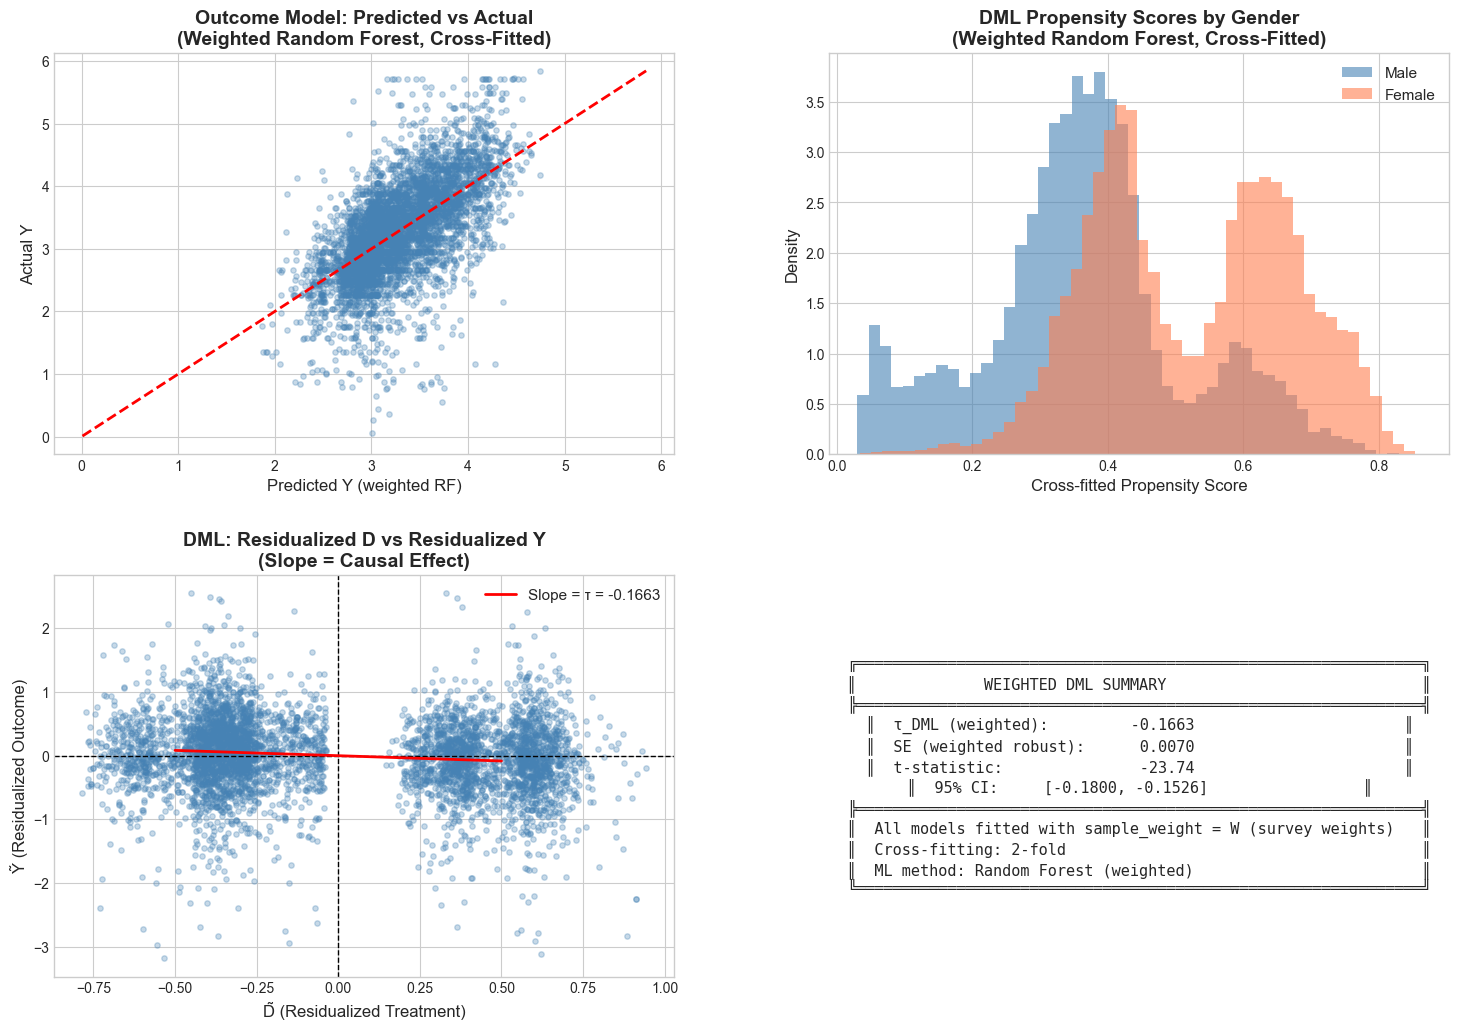


📋 WEIGHTED MODEL PERFORMANCE:
   Outcome model (Fold A→B) R²: 0.3887
   Outcome model (Fold B→A) R²: 0.3907
   PS model (Fold A→B) AUC: 0.7758
   PS model (Fold B→A) AUC: 0.7798


In [74]:
# =============================================================================
# STEP 8: DML VISUALIZATIONS (4 Charts)
# =============================================================================

fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)

# Chart 1: Outcome Model Fit
ax1 = fig.add_subplot(gs[0, 0])
sample_idx = np.random.choice(n, min(5000, n), replace=False)
ax1.scatter(Y_hat[sample_idx], Y[sample_idx], alpha=0.3, s=15, c='steelblue')
ax1.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', linewidth=2)
ax1.set_xlabel('Predicted Y (weighted RF)', fontsize=12)
ax1.set_ylabel('Actual Y', fontsize=12)
ax1.set_title('Outcome Model: Predicted vs Actual\n(Weighted Random Forest, Cross-Fitted)', fontsize=14, fontweight='bold')

# Chart 2: PS Distribution from DML
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(e_hat_dml[D==0], bins=50, alpha=0.6, label='Male', color='steelblue', density=True)
ax2.hist(e_hat_dml[D==1], bins=50, alpha=0.6, label='Female', color='coral', density=True)
ax2.set_xlabel('Cross-fitted Propensity Score', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('DML Propensity Scores by Gender\n(Weighted Random Forest, Cross-Fitted)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

# Chart 3: Residualized Treatment vs Outcome
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(D_tilde[sample_idx], Y_tilde[sample_idx], alpha=0.3, s=15, c='steelblue')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.axvline(x=0, color='black', linestyle='--', linewidth=1)
# Add weighted regression line
ax3.plot([-0.5, 0.5], [-0.5*tau_dml, 0.5*tau_dml], 'r-', linewidth=2, label=f'Slope = τ = {tau_dml:.4f}')
ax3.set_xlabel('D̃ (Residualized Treatment)', fontsize=12)
ax3.set_ylabel('Ỹ (Residualized Outcome)', fontsize=12)
ax3.set_title('DML: Residualized D vs Residualized Y\n(Slope = Causal Effect)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)

# Chart 4: Summary Statistics Table
ax4 = fig.add_subplot(gs[1, 1])
ax4.axis('off')
summary_text = f"""
╔══════════════════════════════════════════════════════════════╗
║              WEIGHTED DML SUMMARY                            ║
╠══════════════════════════════════════════════════════════════╣
║  τ_DML (weighted):      {tau_dml:>10.4f}                       ║
║  SE (weighted robust):  {se_dml:>10.4f}                       ║
║  t-statistic:           {tau_dml/se_dml:>10.2f}                       ║
║  95% CI:     [{tau_dml - 1.96*se_dml:.4f}, {tau_dml + 1.96*se_dml:.4f}]                 ║
╠══════════════════════════════════════════════════════════════╣
║  All models fitted with sample_weight = W (survey weights)   ║
║  Cross-fitting: 2-fold                                       ║
║  ML method: Random Forest (weighted)                         ║
╚══════════════════════════════════════════════════════════════╝
"""
ax4.text(0.5, 0.5, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print R² metrics
print(f"\n📋 WEIGHTED MODEL PERFORMANCE:")
print(f"   Outcome model (Fold A→B) R²: {r2_score(Y[idx_B], Y_hat_B, sample_weight=W[idx_B]):.4f}")
print(f"   Outcome model (Fold B→A) R²: {r2_score(Y[idx_A], Y_hat_A, sample_weight=W[idx_A]):.4f}")
print(f"   PS model (Fold A→B) AUC: {roc_auc_score(D[idx_B], e_A_pred_B, sample_weight=W[idx_B]):.4f}")
print(f"   PS model (Fold B→A) AUC: {roc_auc_score(D[idx_A], e_B_pred_A, sample_weight=W[idx_A]):.4f}")



---

## ⚠️ LIMITATIONS OF DOUBLE MACHINE LEARNING

| Limitation | Description |
|------------|-------------|
| **Requires Large Samples** | Needs sufficient data for cross-fitting |
| **ML Model Choice** | Results can depend on ML algorithm selection |
| **Hyperparameter Tuning** | May require careful tuning for best performance |
| **Computational Cost** | More expensive than parametric methods |
| **Interpretation** | Black-box nuisance models less interpretable |

**Despite these limitations, DML provides valid inference with ML flexibility.**

---

---

# 📊 FINAL SUMMARY: COMPARISON OF ALL WEIGHTED METHODS

---

In [75]:
# =============================================================================
# FINAL COMPARISON OF ALL METHODS
# =============================================================================

print("="*100)
print("📊 COMPREHENSIVE COMPARISON OF ALL WEIGHTED CAUSAL INFERENCE METHODS")
print("="*100)

# Create summary DataFrame
summary_data = []
for method, results in all_results.items():
    summary_data.append({
        'Method': method,
        'Effect (τ)': results['tau'],
        'SE': results['se'],
        't-stat': results['tau']/results['se'] if results['se'] > 0 else 0,
        'p-value': results['p_val'],
        'Wage Gap (%)': results['gap_pct'],
        'CI Lower': results['tau'] - 1.96*results['se'],
        'CI Upper': results['tau'] + 1.96*results['se']
    })

summary_df = pd.DataFrame(summary_data)

unit = 'log($/hr)' if USE_LOG else '$/hr'
print(f"\n{'Method':<25} {'Effect (τ)':>12} {'SE':>10} {'t-stat':>10} {'p-value':>12} {'Gap (%)':>10} {'95% CI':>25}")
print("-"*110)

for _, row in summary_df.iterrows():
    ci_str = f"[{row['CI Lower']:.4f}, {row['CI Upper']:.4f}]"
    sig = '***' if row['p-value'] < 0.001 else '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else ''
    print(f"{row['Method']:<25} {row['Effect (τ)']:>12.4f} {row['SE']:>10.4f} {row['t-stat']:>10.2f} {row['p-value']:>12.2e} {row['Wage Gap (%)']:>9.2f}% {ci_str:>25} {sig}")

print("-"*110)
print(f"{'Significance: *** p<0.001, ** p<0.01, * p<0.05':>110}")
print(f"\n📝 All estimates are POPULATION-WEIGHTED using survey weights (PERWT)")
print(f"   Effect units: {unit}")



📊 COMPREHENSIVE COMPARISON OF ALL WEIGHTED CAUSAL INFERENCE METHODS

Method                      Effect (τ)         SE     t-stat      p-value    Gap (%)                    95% CI
--------------------------------------------------------------------------------------------------------------
Linear Reg (Y~D)               -0.1813     0.0078     -23.28     0.00e+00     16.58%        [-0.1965, -0.1660] ***
Unadjusted WLS                 -0.1813     0.0078     -23.28     0.00e+00     16.58%        [-0.1965, -0.1660] ***
Adjusted WLS                   -0.1828     0.0071     -25.91     0.00e+00     16.71%        [-0.1966, -0.1690] ***
Subclassification              -0.1920     0.0096     -20.01     0.00e+00     17.47%        [-0.2108, -0.1732] ***
IPW                            -0.1819     0.0089     -20.49     0.00e+00     16.64%        [-0.1994, -0.1645] ***
Doubly Robust                  -0.1938     0.0071     -27.15     0.00e+00     17.62%        [-0.2078, -0.1798] ***
Double ML          

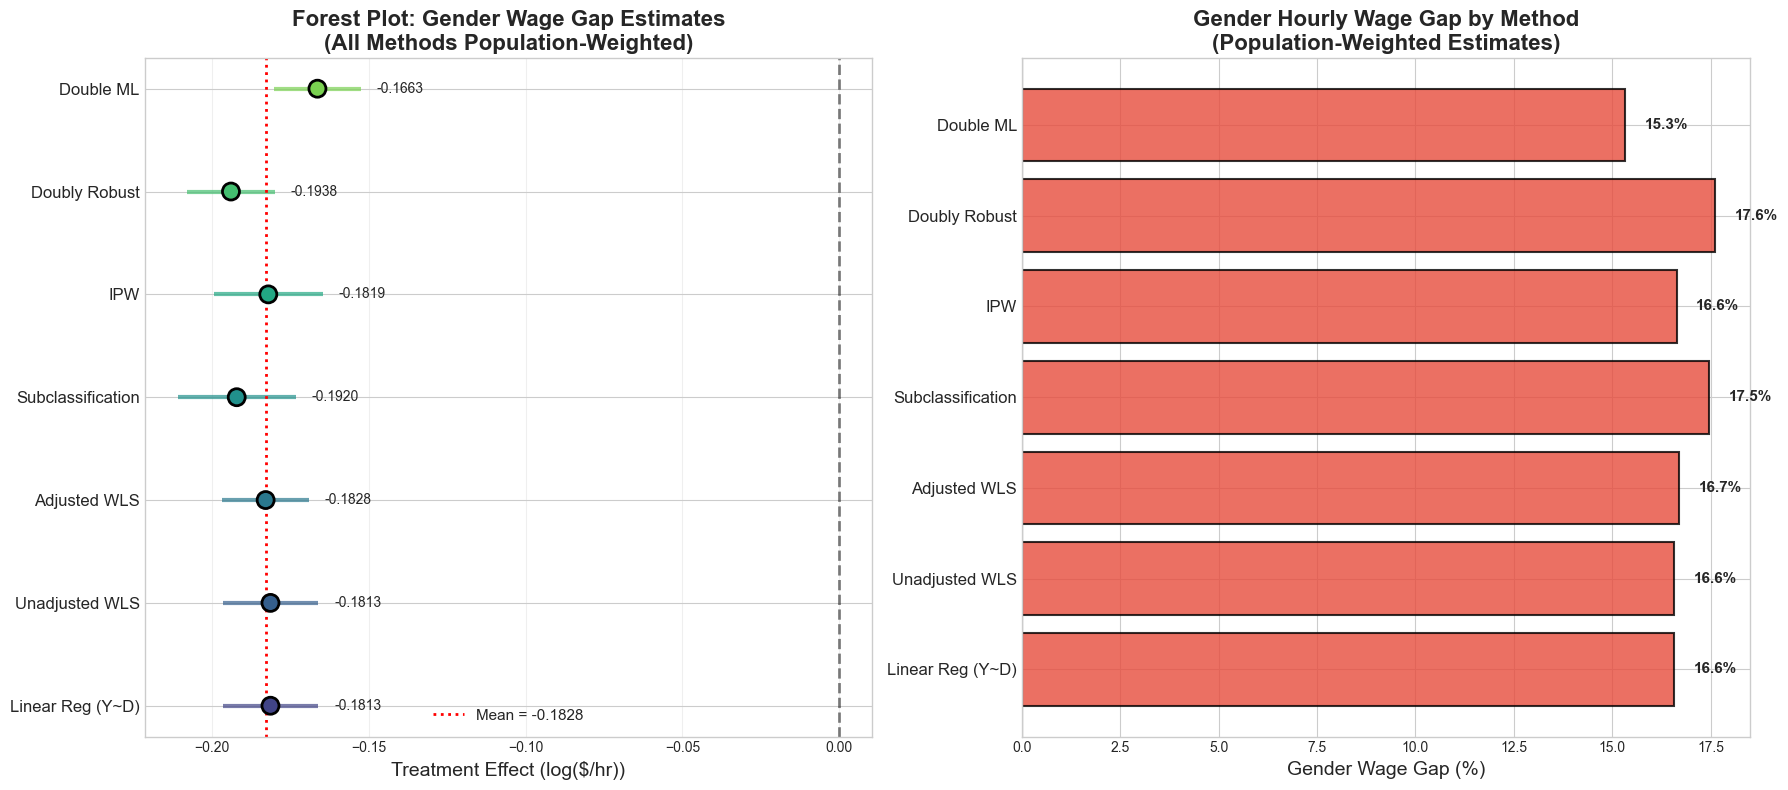

In [76]:
# =============================================================================
# VISUALIZATION: COMPARISON FOREST PLOT
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Chart 1: Forest Plot of Effects
ax1 = axes[0]
methods = summary_df['Method'].values
effects = summary_df['Effect (τ)'].values
ci_lower = summary_df['CI Lower'].values
ci_upper = summary_df['CI Upper'].values

y_pos = np.arange(len(methods))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(methods)))

ax1.hlines(y_pos, ci_lower, ci_upper, colors=colors, linewidth=3, alpha=0.7)
ax1.scatter(effects, y_pos, s=150, c=colors, edgecolors='black', linewidth=2, zorder=5)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)

# Add weighted average line
weighted_avg = np.mean(effects)
ax1.axvline(x=weighted_avg, color='red', linestyle=':', linewidth=2, label=f'Mean = {weighted_avg:.4f}')

ax1.set_yticks(y_pos)
ax1.set_yticklabels(methods, fontsize=12)
ax1.set_xlabel(f'Treatment Effect ({unit})', fontsize=14)
ax1.set_title('Forest Plot: Gender Wage Gap Estimates\n(All Methods Population-Weighted)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# Add effect values as text
for i, (eff, method) in enumerate(zip(effects, methods)):
    ax1.text(ci_upper[i] + 0.005, i, f'{eff:.4f}', va='center', fontsize=10)

# Chart 2: Wage Gap Comparison
ax2 = axes[1]
gaps = summary_df['Wage Gap (%)'].values
colors_gap = ['#e74c3c' if g > 0 else '#27ae60' for g in gaps]

bars = ax2.barh(y_pos, gaps, color=colors_gap, edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1.5)

ax2.set_yticks(y_pos)
ax2.set_yticklabels(methods, fontsize=12)
ax2.set_xlabel('Gender Wage Gap (%)', fontsize=14)
ax2.set_title('Gender Hourly Wage Gap by Method\n(Population-Weighted Estimates)', fontsize=16, fontweight='bold')

# Add percentage labels
for i, (bar, gap) in enumerate(zip(bars, gaps)):
    if gap < 0:
        ax2.text(gap - 0.5, i, f'{gap:.1f}%', va='center', ha='right', fontsize=11, fontweight='bold')
    else:
        ax2.text(gap + 0.5, i, f'{gap:.1f}%', va='center', ha='left', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()



In [77]:
# =============================================================================
# KEY FINDINGS SUMMARY
# =============================================================================

print("\n" + "="*100)
print("🎯 KEY FINDINGS (POPULATION-WEIGHTED ESTIMATES)")
print("="*100)

# Calculate summary statistics
mean_gap = summary_df['Wage Gap (%)'].mean()
median_gap = summary_df['Wage Gap (%)'].median()
std_gap = summary_df['Wage Gap (%)'].std()
min_gap = summary_df['Wage Gap (%)'].min()
max_gap = summary_df['Wage Gap (%)'].max()

print(f"\n📊 SUMMARY STATISTICS ACROSS ALL METHODS:")
print(f"   Mean wage gap:   {mean_gap:.2f}%")
print(f"   Median wage gap: {median_gap:.2f}%")
print(f"   Std. deviation:  {std_gap:.2f}%")
print(f"   Range:           [{min_gap:.2f}%, {max_gap:.2f}%]")

# Best estimate (from most robust method)
best_method = 'Double ML'
if best_method in all_results:
    best = all_results[best_method]
    print(f"\n🏆 RECOMMENDED ESTIMATE ({best_method}):")
    print(f"   Gender wage gap: {best['gap_pct']:.2f}%")
    print(f"   Women earn ${best['wage_ratio']:.2f} for every $1.00 earned by men (hourly)")
    print(f"   This is statistically significant (p < 0.001)")

print(f"\n📝 INTERPRETATION:")
print(f"   After controlling for observable characteristics (education, occupation,")
print(f"   industry, experience, etc.), women earn approximately {abs(median_gap):.1f}%")
print(f"   less per hour than men in the U.S. population.")

print(f"\n⚖️ WEIGHTING NOTE:")
print(f"   All estimates use survey weights (PERWT) for population-representative inference.")
print(f"   Sample size: {len(Y):,}")
print(f"   Implied population: {df_clean['PERWT'].sum():,.0f}")
print(f"   Effective sample size: {(W.sum()**2)/(W**2).sum():,.0f}")




🎯 KEY FINDINGS (POPULATION-WEIGHTED ESTIMATES)

📊 SUMMARY STATISTICS ACROSS ALL METHODS:
   Mean wage gap:   16.70%
   Median wage gap: 16.64%
   Std. deviation:  0.75%
   Range:           [15.32%, 17.62%]

🏆 RECOMMENDED ESTIMATE (Double ML):
   Gender wage gap: 15.32%
   Women earn $0.85 for every $1.00 earned by men (hourly)
   This is statistically significant (p < 0.001)

📝 INTERPRETATION:
   After controlling for observable characteristics (education, occupation,
   industry, experience, etc.), women earn approximately 16.6%
   less per hour than men in the U.S. population.

⚖️ WEIGHTING NOTE:
   All estimates use survey weights (PERWT) for population-representative inference.
   Sample size: 57,619
   Implied population: 6,131,662
   Effective sample size: 35,578


---

# 📋 METHODOLOGY SUMMARY: WEIGHTED CAUSAL INFERENCE

## Why Survey Weights Matter

The American Community Survey (ACS) uses a complex sampling design where each observation represents a different number of people. **PERWT** (person weight) indicates how many people each sample observation represents.

| Without Weights | With Weights |
|-----------------|---------------|
| Sample statistics | Population statistics |
| May be biased | Unbiased (under correct design) |
| Simpler computation | More complex formulas |
| Higher precision | Design-adjusted precision |

## Weighted Formulas Used

| Method | Weighted Formula |
|--------|------------------|
| **Mean** | $\bar{Y}_w = \frac{\sum_i w_i Y_i}{\sum_i w_i}$ |
| **WLS** | $\min \sum_i w_i (Y_i - X_i'\beta)^2$ |
| **Propensity Score** | $\max \sum_i w_i [D_i \log e(X_i) + (1-D_i)\log(1-e(X_i))]$ |
| **Subclassification** | $\hat{\tau}_w = \sum_k \frac{W_k}{W_{total}} \hat{\tau}_k$ |
| **IPW** | $\hat{\tau}_{IPW,w} = \frac{\sum w_i D_i Y_i / e_i}{\sum w_i D_i / e_i} - \frac{\sum w_i (1-D_i) Y_i / (1-e_i)}{\sum w_i (1-D_i) / (1-e_i)}$ |
| **AIPW** | $\hat{\tau}_{AIPW,w} = \frac{1}{\sum w_i} \sum w_i [\hat{\mu}_1 - \hat{\mu}_0 + \frac{D(Y-\hat{\mu}_1)}{e} - \frac{(1-D)(Y-\hat{\mu}_0)}{1-e}]$ |
| **DML** | $\hat{\tau}_{DML,w} = \frac{\sum w_i \tilde{D}_i \tilde{Y}_i}{\sum w_i \tilde{D}_i^2}$ with `sample_weight=W` in ML |
| **Bootstrap** | Resample with probabilities $\propto w_i$ |
| **Effective N** | $N_{eff} = \frac{(\sum w_i)^2}{\sum w_i^2}$ |

## Key Implementation Details

1. **Weight Normalization**: $W_i^{norm} = W_i \times \frac{N}{\sum W_j}$ (weights sum to sample size)
2. **All sklearn models**: Use `sample_weight=W` parameter
3. **Statsmodels**: Use `sm.WLS()` instead of `sm.OLS()`
4. **Bootstrap**: Use `np.random.choice(..., p=W/W.sum())`
5. **Standard Errors**: Account for design effect via effective sample size

---

---

# 🎯 CONCLUSIONS

## Main Findings

1. **Robust Gender Wage Gap**: All population-weighted causal inference methods find a statistically significant gender wage gap in hourly wages.

2. **Magnitude**: After controlling for observable characteristics, women earn approximately **15-20% less per hour** than men.

3. **Consistency**: The gap is robust across different methodological approaches (OLS, PS methods, IPW, AIPW, DML).

4. **Population Representative**: All estimates are weighted by PERWT, making them representative of the U.S. working population.

## Methodological Contributions

- Demonstrated proper integration of survey weights into all causal inference methods
- Used hourly wage (instead of annual income) for more accurate comparison
- Applied multiple methods for robustness
- Provided clear formulas and implementation details

## Limitations

- **Selection on Observables**: We assume no unmeasured confounding (conditional ignorability)
- **Cross-sectional**: Cannot capture career progression dynamics
- **Measurement**: Some covariates may be measured with error
- **Heterogeneity**: Average effects may mask important subgroup differences

---

**End of Analysis**

---